In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (specific humidity) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (specific humidity) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (specific humidity) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (specific humidity) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 10
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when ONI is removed as a predictor
df_trimmed = df_trimmed.drop(['ONI'], axis=1)

n_vars = df_trimmed.shape[1]-1

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 15
n_seq (number of output/future prediction time steps): 10
C:\Users\User
C:\Users\User\Modeling\
     file_id        date  specific_humidity          slp  vapor_pressure  \
0       6678  1998-12-31          12.816968  1016.202508       20.726068   
1       6678  1999-12-31          12.330412  1017.480181       19.960131   
2       6678  2000-12-31          12.136613  1018.259826       19.655271   
3       6678  2001-12-31          11.897962  1018.414173       19.285320   
4       6678  2002-12-31          12.751085  1017.916636       20.638060   
..       ...         ...                ...          ...             ...   
643     8000  2020-12-31           5.146134  1016.944161        8.168785   
644     8000  2021-12-31           5.239193  1016.159983        8.312383   
645     8000  2022-12-31           5.362553  1017.898453        8.512894   
646     8000  2023-12-31           5.430746  1016.166709        8.612808   
647     800

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

10
15
(19, 175)
(2, 175)


[I 2025-06-06 22:43:08,510] A new study created in memory with name: no-name-9d5fcb7a-3a99-44c3-980e-26011aee718a
[I 2025-06-06 22:45:01,586] Trial 0 finished with value: 4.262685012817383 and parameters: {'lr': 0.4104625812447002, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.30319736835220007}. Best is trial 0 with value: 4.262685012817383.


Cross Validation Accuracies:
[4.005316734313965, 5.078414440155029, 3.259101629257202, 5.141960620880127, 3.828631639480591]
Mean Cross Validation Accuracy:
4.262685012817383
Standard Deviation of Cross Validation Accuracy:
0.7348959739992695


[I 2025-06-06 22:46:17,059] Trial 1 finished with value: 0.09062457382678986 and parameters: {'lr': 0.6649567424762964, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.12288152873093972}. Best is trial 1 with value: 0.09062457382678986.


Cross Validation Accuracies:
[0.09126707911491394, 0.09696400165557861, 0.08097472041845322, 0.10677527636289597, 0.07714179158210754]
Mean Cross Validation Accuracy:
0.09062457382678986
Standard Deviation of Cross Validation Accuracy:
0.010736400127709286


[I 2025-06-06 22:47:24,737] Trial 2 finished with value: 0.08923348039388657 and parameters: {'lr': 0.0015675176734890387, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.25874987648244163}. Best is trial 2 with value: 0.08923348039388657.


Cross Validation Accuracies:
[0.0942610651254654, 0.09115888923406601, 0.08575648814439774, 0.10462713241577148, 0.07036382704973221]
Mean Cross Validation Accuracy:
0.08923348039388657
Standard Deviation of Cross Validation Accuracy:
0.0112614530362426


[I 2025-06-06 22:48:19,858] Trial 3 finished with value: 0.11676838248968124 and parameters: {'lr': 0.0013332129205154153, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.4900008515669506}. Best is trial 2 with value: 0.08923348039388657.


Cross Validation Accuracies:
[0.08736561983823776, 0.1201246902346611, 0.13071715831756592, 0.10689542442560196, 0.13873901963233948]
Mean Cross Validation Accuracy:
0.11676838248968124
Standard Deviation of Cross Validation Accuracy:
0.01816887337014672


[I 2025-06-06 22:50:13,546] Trial 4 finished with value: 0.1379939630627632 and parameters: {'lr': 0.0076983303383271525, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.18750675783779291}. Best is trial 2 with value: 0.08923348039388657.


Cross Validation Accuracies:
[0.12412365525960922, 0.13923650979995728, 0.1542433202266693, 0.13457290828227997, 0.1377934217453003]
Mean Cross Validation Accuracy:
0.1379939630627632
Standard Deviation of Cross Validation Accuracy:
0.009692417673827409


[I 2025-06-06 22:51:56,698] Trial 5 finished with value: 0.0915161520242691 and parameters: {'lr': 0.002003681366683839, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.15435760655849534}. Best is trial 2 with value: 0.08923348039388657.


Cross Validation Accuracies:
[0.09969921410083771, 0.09351702034473419, 0.0841214656829834, 0.10558947175741196, 0.07465358823537827]
Mean Cross Validation Accuracy:
0.0915161520242691
Standard Deviation of Cross Validation Accuracy:
0.01102770829244675


[I 2025-06-06 22:52:58,560] Trial 6 finished with value: 0.5542929947376252 and parameters: {'lr': 0.007919396844938307, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.38416737757702524}. Best is trial 2 with value: 0.08923348039388657.


Cross Validation Accuracies:
[0.5997670292854309, 0.614944338798523, 0.5510728359222412, 0.4907964766025543, 0.5148842930793762]
Mean Cross Validation Accuracy:
0.5542929947376252
Standard Deviation of Cross Validation Accuracy:
0.04762708548486035


[I 2025-06-06 22:54:45,001] Trial 7 finished with value: 0.2971773505210876 and parameters: {'lr': 0.04166371714176694, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.24693846949405482}. Best is trial 2 with value: 0.08923348039388657.


Cross Validation Accuracies:
[0.1760418713092804, 0.40623027086257935, 0.3100990951061249, 0.280695378780365, 0.3128201365470886]
Mean Cross Validation Accuracy:
0.2971773505210876
Standard Deviation of Cross Validation Accuracy:
0.07382366475476558


[I 2025-06-06 22:56:08,210] Trial 8 finished with value: 0.09705410152673721 and parameters: {'lr': 0.003519477808830015, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3660848932103914}. Best is trial 2 with value: 0.08923348039388657.


Cross Validation Accuracies:
[0.09473569691181183, 0.10114779323339462, 0.08420263975858688, 0.12000241875648499, 0.08518195897340775]
Mean Cross Validation Accuracy:
0.09705410152673721
Standard Deviation of Cross Validation Accuracy:
0.013075675231586379


[I 2025-06-06 22:57:12,412] Trial 9 finished with value: 0.1619396150112152 and parameters: {'lr': 0.5714347401999031, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2162324837939046}. Best is trial 2 with value: 0.08923348039388657.


Cross Validation Accuracies:
[0.09274132549762726, 0.4545735716819763, 0.08382774144411087, 0.10555819422006607, 0.07299724221229553]
Mean Cross Validation Accuracy:
0.1619396150112152
Standard Deviation of Cross Validation Accuracy:
0.14670658536690515


[I 2025-06-06 22:58:06,857] Trial 10 finished with value: 0.16491166055202483 and parameters: {'lr': 0.10042405296073259, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.299945311082179}. Best is trial 2 with value: 0.08923348039388657.


Cross Validation Accuracies:
[0.1422215700149536, 0.15363097190856934, 0.1523161232471466, 0.2008497416973114, 0.17553989589214325]
Mean Cross Validation Accuracy:
0.16491166055202483
Standard Deviation of Cross Validation Accuracy:
0.021001175051409852


[I 2025-06-06 22:59:07,530] Trial 11 finished with value: 0.09058567136526108 and parameters: {'lr': 0.16236780966342376, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.12481917351055463}. Best is trial 2 with value: 0.08923348039388657.


Cross Validation Accuracies:
[0.09500130265951157, 0.0923861414194107, 0.08625112473964691, 0.10583606362342834, 0.07345372438430786]
Mean Cross Validation Accuracy:
0.09058567136526108
Standard Deviation of Cross Validation Accuracy:
0.010654631462218081


[I 2025-06-06 23:00:10,112] Trial 12 finished with value: 0.08987792283296585 and parameters: {'lr': 0.12073046638815504, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2653009519453557}. Best is trial 2 with value: 0.08923348039388657.


Cross Validation Accuracies:
[0.09380068629980087, 0.0933581069111824, 0.08211719989776611, 0.10851287096738815, 0.07160075008869171]
Mean Cross Validation Accuracy:
0.08987792283296585
Standard Deviation of Cross Validation Accuracy:
0.012401974926668651


[I 2025-06-06 23:01:08,449] Trial 13 finished with value: 0.08947582989931106 and parameters: {'lr': 0.02340405614412046, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2836644440666972}. Best is trial 2 with value: 0.08923348039388657.


Cross Validation Accuracies:
[0.09382754564285278, 0.0938866063952446, 0.08394002169370651, 0.10439450293779373, 0.0713304728269577]
Mean Cross Validation Accuracy:
0.08947582989931106
Standard Deviation of Cross Validation Accuracy:
0.0111432341823302


[I 2025-06-06 23:02:09,197] Trial 14 finished with value: 0.09098629951477051 and parameters: {'lr': 0.02312312180169713, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3683335579898641}. Best is trial 2 with value: 0.08923348039388657.


Cross Validation Accuracies:
[0.09845564514398575, 0.09459448605775833, 0.08193128556013107, 0.10723724216222763, 0.07271283864974976]
Mean Cross Validation Accuracy:
0.09098629951477051
Standard Deviation of Cross Validation Accuracy:
0.012237776929596125


[I 2025-06-06 23:03:15,622] Trial 15 finished with value: 0.0891393169760704 and parameters: {'lr': 0.017687516506987962, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3132399322037613}. Best is trial 15 with value: 0.0891393169760704.


Cross Validation Accuracies:
[0.09148111939430237, 0.09213633835315704, 0.0845063179731369, 0.10298489779233932, 0.07458791136741638]
Mean Cross Validation Accuracy:
0.0891393169760704
Standard Deviation of Cross Validation Accuracy:
0.009374159896111607


[I 2025-06-06 23:04:33,333] Trial 16 finished with value: 0.09367179572582245 and parameters: {'lr': 0.008227234167581284, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.43757565998538833}. Best is trial 15 with value: 0.0891393169760704.


Cross Validation Accuracies:
[0.09641143679618835, 0.09899796545505524, 0.08733084797859192, 0.11551225185394287, 0.07010647654533386]
Mean Cross Validation Accuracy:
0.09367179572582245
Standard Deviation of Cross Validation Accuracy:
0.014888996792764753


[I 2025-06-06 23:06:05,736] Trial 17 finished with value: 0.0895127758383751 and parameters: {'lr': 0.003487199154350184, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.32865536762761655}. Best is trial 15 with value: 0.0891393169760704.


Cross Validation Accuracies:
[0.09249281138181686, 0.08829854428768158, 0.08665084093809128, 0.10686036944389343, 0.0732613131403923]
Mean Cross Validation Accuracy:
0.0895127758383751
Standard Deviation of Cross Validation Accuracy:
0.01080365387448603


[I 2025-06-06 23:07:56,401] Trial 18 finished with value: 0.08882635086774826 and parameters: {'lr': 0.0011376350580233974, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.21527636799577682}. Best is trial 18 with value: 0.08882635086774826.


Cross Validation Accuracies:
[0.08971128612756729, 0.09148611128330231, 0.08375369757413864, 0.10616668313741684, 0.07301397621631622]
Mean Cross Validation Accuracy:
0.08882635086774826
Standard Deviation of Cross Validation Accuracy:
0.010810250345474406


[I 2025-06-06 23:10:22,127] Trial 19 finished with value: 0.15695222318172455 and parameters: {'lr': 0.061334312900683696, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.203465909105581}. Best is trial 18 with value: 0.08882635086774826.


Cross Validation Accuracies:
[0.1924809366464615, 0.18506811559200287, 0.1593707650899887, 0.12629301846027374, 0.12154828011989594]
Mean Cross Validation Accuracy:
0.15695222318172455
Standard Deviation of Cross Validation Accuracy:
0.02916185265007966


[I 2025-06-06 23:13:01,049] Trial 20 finished with value: 0.08676079213619232 and parameters: {'lr': 0.013304446081969963, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.33355491737701903}. Best is trial 20 with value: 0.08676079213619232.


Cross Validation Accuracies:
[0.08894249051809311, 0.09114982187747955, 0.08453049510717392, 0.1001407653093338, 0.06904038786888123]
Mean Cross Validation Accuracy:
0.08676079213619232
Standard Deviation of Cross Validation Accuracy:
0.01021796480957009


[I 2025-06-06 23:15:35,958] Trial 21 finished with value: 0.09317563325166703 and parameters: {'lr': 0.013067500896013459, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.33877429341577925}. Best is trial 20 with value: 0.08676079213619232.


Cross Validation Accuracies:
[0.09718326479196548, 0.09756900370121002, 0.08521011471748352, 0.11163391917943954, 0.07428186386823654]
Mean Cross Validation Accuracy:
0.09317563325166703
Standard Deviation of Cross Validation Accuracy:
0.012621371881802658


[I 2025-06-06 23:18:30,042] Trial 22 finished with value: 0.09185939133167267 and parameters: {'lr': 0.003942678777038206, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.41345889787322015}. Best is trial 20 with value: 0.08676079213619232.


Cross Validation Accuracies:
[0.09677021205425262, 0.09815873950719833, 0.08214432001113892, 0.11200117319822311, 0.07022251188755035]
Mean Cross Validation Accuracy:
0.09185939133167267
Standard Deviation of Cross Validation Accuracy:
0.014366812361885011


[I 2025-06-06 23:21:46,578] Trial 23 finished with value: 0.0863314464688301 and parameters: {'lr': 0.014463668045274741, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.23143443114203002}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09059956669807434, 0.09622499346733093, 0.07758129388093948, 0.10037145763635635, 0.06687992066144943]
Mean Cross Validation Accuracy:
0.0863314464688301
Standard Deviation of Cross Validation Accuracy:
0.012394741325527174


[I 2025-06-06 23:24:40,585] Trial 24 finished with value: 0.0892702504992485 and parameters: {'lr': 0.03832395733721044, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.23478728390144873}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09217631071805954, 0.09638099372386932, 0.0834285095334053, 0.10481851547956467, 0.06954692304134369]
Mean Cross Validation Accuracy:
0.0892702504992485
Standard Deviation of Cross Validation Accuracy:
0.012032389476938698


[I 2025-06-06 23:27:55,482] Trial 25 finished with value: 0.10458705574274063 and parameters: {'lr': 0.0010304961587158528, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.17314714582400698}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.11924881488084793, 0.09523297846317291, 0.11658473312854767, 0.1080639585852623, 0.08380479365587234]
Mean Cross Validation Accuracy:
0.10458705574274063
Standard Deviation of Cross Validation Accuracy:
0.013344672916587516


[I 2025-06-06 23:30:39,919] Trial 26 finished with value: 0.09079854190349579 and parameters: {'lr': 0.01204109144721055, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.21712066944597547}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09860903024673462, 0.09292392432689667, 0.08506183326244354, 0.10457084327936172, 0.07282707840204239]
Mean Cross Validation Accuracy:
0.09079854190349579
Standard Deviation of Cross Validation Accuracy:
0.011055139892463098


[I 2025-06-06 23:33:18,687] Trial 27 finished with value: 0.522816252708435 and parameters: {'lr': 0.22590586298892856, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1552550007424894}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.581296980381012, 0.4992009401321411, 0.6944580078125, 0.35983482003211975, 0.47929051518440247]
Mean Cross Validation Accuracy:
0.522816252708435
Standard Deviation of Cross Validation Accuracy:
0.11126186032655506


[I 2025-06-06 23:37:05,946] Trial 28 finished with value: 0.09556182622909545 and parameters: {'lr': 0.00524561237607036, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.276891800752469}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09338662773370743, 0.10029062628746033, 0.09370885044336319, 0.11155135929584503, 0.07887166738510132]
Mean Cross Validation Accuracy:
0.09556182622909545
Standard Deviation of Cross Validation Accuracy:
0.010627823179553506


[I 2025-06-06 23:40:38,072] Trial 29 finished with value: 0.1394152507185936 and parameters: {'lr': 0.00225817413496113, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.10254889687665097}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.16021884977817535, 0.127089262008667, 0.142592191696167, 0.1613362580537796, 0.10583969205617905]
Mean Cross Validation Accuracy:
0.1394152507185936
Standard Deviation of Cross Validation Accuracy:
0.02098886079598687


[I 2025-06-06 23:44:01,514] Trial 30 finished with value: 0.3867991745471954 and parameters: {'lr': 0.07337016457892558, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.23264786421856348}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.4789149761199951, 0.3028993606567383, 0.3645491600036621, 0.4894344210624695, 0.2981979548931122]
Mean Cross Validation Accuracy:
0.3867991745471954
Standard Deviation of Cross Validation Accuracy:
0.08295026554373697


[I 2025-06-06 23:46:39,204] Trial 31 finished with value: 0.08979119807481765 and parameters: {'lr': 0.016954426343733623, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3187799724301572}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09005967527627945, 0.0949835404753685, 0.08456302434206009, 0.10505614429712296, 0.0742936059832573]
Mean Cross Validation Accuracy:
0.08979119807481765
Standard Deviation of Cross Validation Accuracy:
0.010271905801733447


[I 2025-06-06 23:48:54,033] Trial 32 finished with value: 0.08927429914474487 and parameters: {'lr': 0.020430790147623067, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.30087554666943617}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09109591692686081, 0.09176547080278397, 0.0821167379617691, 0.10866017639636993, 0.07273319363594055]
Mean Cross Validation Accuracy:
0.08927429914474487
Standard Deviation of Cross Validation Accuracy:
0.011917846432392477


[I 2025-06-06 23:51:44,211] Trial 33 finished with value: 0.09401133954524994 and parameters: {'lr': 0.033535576045186394, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3347005224709295}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.0923413336277008, 0.09231850504875183, 0.1080394834280014, 0.10432889312505722, 0.07302848249673843]
Mean Cross Validation Accuracy:
0.09401133954524994
Standard Deviation of Cross Validation Accuracy:
0.012240715918465091


[I 2025-06-06 23:54:41,797] Trial 34 finished with value: 0.09195370227098465 and parameters: {'lr': 0.005633349219407425, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.26058849547662233}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.10403365641832352, 0.08831585943698883, 0.08809149265289307, 0.10578576475381851, 0.07354173809289932]
Mean Cross Validation Accuracy:
0.09195370227098465
Standard Deviation of Cross Validation Accuracy:
0.01186930691527404


[I 2025-06-06 23:57:14,528] Trial 35 finished with value: 0.08902122229337692 and parameters: {'lr': 0.011727047241269384, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.35813986443140045}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.08450966328382492, 0.09371227025985718, 0.08458296209573746, 0.10420206934213638, 0.07809914648532867]
Mean Cross Validation Accuracy:
0.08902122229337692
Standard Deviation of Cross Validation Accuracy:
0.00907533036728714


[I 2025-06-06 23:59:43,330] Trial 36 finished with value: 0.11930711716413497 and parameters: {'lr': 0.011950049944100543, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4438079242275228}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.1113513708114624, 0.10509730130434036, 0.09507916122674942, 0.19226980209350586, 0.09273795038461685]
Mean Cross Validation Accuracy:
0.11930711716413497
Standard Deviation of Cross Validation Accuracy:
0.03709900438330313


[I 2025-06-07 00:02:49,923] Trial 37 finished with value: 0.09186779409646988 and parameters: {'lr': 0.001919177913021643, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3492102126062188}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09346091747283936, 0.09326210618019104, 0.08714914321899414, 0.10558177530765533, 0.07988502830266953]
Mean Cross Validation Accuracy:
0.09186779409646988
Standard Deviation of Cross Validation Accuracy:
0.008466495982547536


[I 2025-06-07 00:06:18,627] Trial 38 finished with value: 0.4156563520431519 and parameters: {'lr': 0.05410101251634304, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4008862299489885}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.6169386506080627, 0.42490923404693604, 0.3275403380393982, 0.3484710156917572, 0.3604225218296051]
Mean Cross Validation Accuracy:
0.4156563520431519
Standard Deviation of Cross Validation Accuracy:
0.10576318535820348


[I 2025-06-07 00:09:24,175] Trial 39 finished with value: 0.10899397879838943 and parameters: {'lr': 0.008959154009453147, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.19325024906559313}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.15382449328899384, 0.09736256301403046, 0.10467158257961273, 0.11025366187095642, 0.07885759323835373]
Mean Cross Validation Accuracy:
0.10899397879838943
Standard Deviation of Cross Validation Accuracy:
0.024793291462730245


[I 2025-06-07 00:12:27,198] Trial 40 finished with value: 0.09272397011518478 and parameters: {'lr': 0.0030102109502465665, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3655847766543739}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.10386601090431213, 0.09779272228479385, 0.0760536938905716, 0.10565926879644394, 0.0802481546998024]
Mean Cross Validation Accuracy:
0.09272397011518478
Standard Deviation of Cross Validation Accuracy:
0.012253190222635702


[I 2025-06-07 00:15:14,361] Trial 41 finished with value: 0.08984434008598327 and parameters: {'lr': 0.015920490960863783, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3059733108490491}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09247862547636032, 0.09203799813985825, 0.08491533994674683, 0.1041022390127182, 0.07568749785423279]
Mean Cross Validation Accuracy:
0.08984434008598327
Standard Deviation of Cross Validation Accuracy:
0.009378171477719317


[I 2025-06-07 00:17:42,481] Trial 42 finished with value: 2.9913044452667235 and parameters: {'lr': 0.9305737722277155, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2904309264877242}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[2.5287203788757324, 2.6318535804748535, 3.465026617050171, 3.71185564994812, 2.619065999984741]
Mean Cross Validation Accuracy:
2.9913044452667235
Standard Deviation of Cross Validation Accuracy:
0.49504689422951303


[I 2025-06-07 00:20:33,354] Trial 43 finished with value: 0.09089627116918564 and parameters: {'lr': 0.009767326327424192, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.35132471808126764}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09222020208835602, 0.09967773407697678, 0.08279603719711304, 0.10803630203008652, 0.07175108045339584]
Mean Cross Validation Accuracy:
0.09089627116918564
Standard Deviation of Cross Validation Accuracy:
0.012686998539753714


[I 2025-06-07 00:23:02,409] Trial 44 finished with value: 0.0919412299990654 and parameters: {'lr': 0.005598870495991417, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3833411936623698}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09338608384132385, 0.09300130605697632, 0.08092134445905685, 0.10803090780973434, 0.08436650782823563]
Mean Cross Validation Accuracy:
0.0919412299990654
Standard Deviation of Cross Validation Accuracy:
0.00939045674294203


[I 2025-06-07 00:25:39,059] Trial 45 finished with value: 0.09271782785654067 and parameters: {'lr': 0.028724152228653613, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.24907305151643405}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09332369267940521, 0.09250994771718979, 0.10073553770780563, 0.10519247502088547, 0.0718274861574173]
Mean Cross Validation Accuracy:
0.09271782785654067
Standard Deviation of Cross Validation Accuracy:
0.011460516181883092


[I 2025-06-07 00:28:44,359] Trial 46 finished with value: 0.08848439753055573 and parameters: {'lr': 0.017304448000031225, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3190013978800541}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.0883713811635971, 0.09295252710580826, 0.08457775413990021, 0.10521191358566284, 0.07130841165781021]
Mean Cross Validation Accuracy:
0.08848439753055573
Standard Deviation of Cross Validation Accuracy:
0.011045932294349982


[I 2025-06-07 00:32:11,044] Trial 47 finished with value: 0.2847885191440582 and parameters: {'lr': 0.006477770950840575, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.17717079505137293}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.2615143358707428, 0.2751816511154175, 0.21338191628456116, 0.37502023577690125, 0.29884445667266846]
Mean Cross Validation Accuracy:
0.2847885191440582
Standard Deviation of Cross Validation Accuracy:
0.053051323298502935


[I 2025-06-07 00:36:00,255] Trial 48 finished with value: 0.0880988970398903 and parameters: {'lr': 0.3382845665454589, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.22976308884511595}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.08847109228372574, 0.09221550077199936, 0.08150309324264526, 0.10631704330444336, 0.07198775559663773]
Mean Cross Validation Accuracy:
0.0880988970398903
Standard Deviation of Cross Validation Accuracy:
0.01141980135763875


[I 2025-06-07 00:39:43,089] Trial 49 finished with value: 0.09190914332866669 and parameters: {'lr': 0.2718454658947233, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2205786975087668}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09833936393260956, 0.09296704828739166, 0.08901699632406235, 0.10902874171733856, 0.0701935663819313]
Mean Cross Validation Accuracy:
0.09190914332866669
Standard Deviation of Cross Validation Accuracy:
0.012770891475009174


[I 2025-06-07 00:42:55,925] Trial 50 finished with value: 0.09058810174465179 and parameters: {'lr': 0.08876699263403724, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.15359954024686087}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09752439707517624, 0.09437797218561172, 0.08166449517011642, 0.10632526874542236, 0.07304837554693222]
Mean Cross Validation Accuracy:
0.09058810174465179
Standard Deviation of Cross Validation Accuracy:
0.011810220027329893


[I 2025-06-07 00:46:04,581] Trial 51 finished with value: 0.0915249764919281 and parameters: {'lr': 0.3853023598075608, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.27275384700560934}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09348529577255249, 0.0933697447180748, 0.09011857956647873, 0.10703293234109879, 0.0736183300614357]
Mean Cross Validation Accuracy:
0.0915249764919281
Standard Deviation of Cross Validation Accuracy:
0.010680530462562196


[I 2025-06-07 00:49:23,365] Trial 52 finished with value: 0.08849602788686753 and parameters: {'lr': 0.027799090607684814, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.24146291323284486}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09089160710573196, 0.09395124018192291, 0.08433463424444199, 0.1049879789352417, 0.06831467896699905]
Mean Cross Validation Accuracy:
0.08849602788686753
Standard Deviation of Cross Validation Accuracy:
0.012100302736978482


[I 2025-06-07 00:52:54,786] Trial 53 finished with value: 0.09013268947601319 and parameters: {'lr': 0.052003103428302985, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.24532523207846574}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09475990384817123, 0.09187997877597809, 0.08601947873830795, 0.10816305875778198, 0.06984102725982666]
Mean Cross Validation Accuracy:
0.09013268947601319
Standard Deviation of Cross Validation Accuracy:
0.012475803839827037


[I 2025-06-07 00:56:25,933] Trial 54 finished with value: 0.08966196477413177 and parameters: {'lr': 0.027800157213664044, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.20018724889208586}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09184716641902924, 0.09112843871116638, 0.08452426642179489, 0.10714799165725708, 0.07366196066141129]
Mean Cross Validation Accuracy:
0.08966196477413177
Standard Deviation of Cross Validation Accuracy:
0.01090947170270791


[I 2025-06-07 00:59:51,314] Trial 55 finished with value: 0.08869532942771911 and parameters: {'lr': 0.13650689678345856, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.23461976749040336}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09097430109977722, 0.09082131087779999, 0.08247314393520355, 0.10604093968868256, 0.07316695153713226]
Mean Cross Validation Accuracy:
0.08869532942771911
Standard Deviation of Cross Validation Accuracy:
0.010866736552889365


[I 2025-06-07 01:03:13,328] Trial 56 finished with value: 0.09296558201313018 and parameters: {'lr': 0.1450852988503364, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.28617166540454175}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09511351585388184, 0.09718798846006393, 0.09334076195955276, 0.10077332705259323, 0.07841231673955917]
Mean Cross Validation Accuracy:
0.09296558201313018
Standard Deviation of Cross Validation Accuracy:
0.007685590526481868


[I 2025-06-07 01:06:43,251] Trial 57 finished with value: 0.0922019511461258 and parameters: {'lr': 0.37696390385402184, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.23635279414822308}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09405352175235748, 0.09431024640798569, 0.0879666805267334, 0.10792965441942215, 0.07674965262413025]
Mean Cross Validation Accuracy:
0.0922019511461258
Standard Deviation of Cross Validation Accuracy:
0.01011874418795389


[I 2025-06-07 01:10:44,601] Trial 58 finished with value: 0.09675738066434861 and parameters: {'lr': 0.20996734256518212, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.25379691205031496}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.10192117094993591, 0.10359501093626022, 0.08948312699794769, 0.11117585748434067, 0.07761173695325851]
Mean Cross Validation Accuracy:
0.09675738066434861
Standard Deviation of Cross Validation Accuracy:
0.01183875695478784


[I 2025-06-07 01:14:02,179] Trial 59 finished with value: 0.08918704837560654 and parameters: {'lr': 0.5049141538153219, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.270999009079296}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09135355055332184, 0.09153028577566147, 0.08556851744651794, 0.10612127929925919, 0.07136160880327225]
Mean Cross Validation Accuracy:
0.08918704837560654
Standard Deviation of Cross Validation Accuracy:
0.011205291002079036


[I 2025-06-07 01:17:19,271] Trial 60 finished with value: 0.08895613104104996 and parameters: {'lr': 0.044030763623167817, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.22079526893014392}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.08987454324960709, 0.09393831342458725, 0.08571566641330719, 0.10571674257516861, 0.06953538954257965]
Mean Cross Validation Accuracy:
0.08895613104104996
Standard Deviation of Cross Validation Accuracy:
0.011783459022200113


[I 2025-06-07 01:20:07,195] Trial 61 finished with value: 0.08962722271680831 and parameters: {'lr': 0.023727179751583387, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2105982149699586}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09298482537269592, 0.09214090555906296, 0.08657597750425339, 0.10295305401086807, 0.07348135113716125]
Mean Cross Validation Accuracy:
0.08962722271680831
Standard Deviation of Cross Validation Accuracy:
0.009645404533948852


[I 2025-06-07 01:23:30,104] Trial 62 finished with value: 0.09028609991073608 and parameters: {'lr': 0.7115191301594872, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1734768014556265}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09120350331068039, 0.09309107065200806, 0.08726745843887329, 0.10432813316583633, 0.07554033398628235]
Mean Cross Validation Accuracy:
0.09028609991073608
Standard Deviation of Cross Validation Accuracy:
0.00929987093275378


[I 2025-06-07 01:27:17,977] Trial 63 finished with value: 0.0887397974729538 and parameters: {'lr': 0.10391084184460507, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.23378959635875818}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.08624573051929474, 0.09661643952131271, 0.08508509397506714, 0.10627897083759308, 0.06947275251150131]
Mean Cross Validation Accuracy:
0.0887397974729538
Standard Deviation of Cross Validation Accuracy:
0.012332561302878478


[I 2025-06-07 01:30:58,239] Trial 64 finished with value: 0.09139762818813324 and parameters: {'lr': 0.10906779055035168, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.23187979394134806}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.0946129709482193, 0.09800522029399872, 0.08179951459169388, 0.10732828080654144, 0.07524215430021286]
Mean Cross Validation Accuracy:
0.09139762818813324
Standard Deviation of Cross Validation Accuracy:
0.011497021496928335


[I 2025-06-07 01:34:45,141] Trial 65 finished with value: 0.09505971819162369 and parameters: {'lr': 0.14293220727817302, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3202754590910195}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.08974991738796234, 0.09681504219770432, 0.09209500998258591, 0.11763841658830643, 0.07900020480155945]
Mean Cross Validation Accuracy:
0.09505971819162369
Standard Deviation of Cross Validation Accuracy:
0.012710391286814407


[I 2025-06-07 01:38:52,316] Trial 66 finished with value: 0.08951365798711777 and parameters: {'lr': 0.07081921102140544, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.26137547023802976}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09086018055677414, 0.09265568107366562, 0.08255375921726227, 0.10939156264066696, 0.07210710644721985]
Mean Cross Validation Accuracy:
0.08951365798711777
Standard Deviation of Cross Validation Accuracy:
0.01231458284247051


[I 2025-06-07 01:42:35,640] Trial 67 finished with value: 0.08882421851158143 and parameters: {'lr': 0.014937587336522626, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.18462359139288437}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09286847710609436, 0.09125404804944992, 0.08304016292095184, 0.10282391309738159, 0.07413449138402939]
Mean Cross Validation Accuracy:
0.08882421851158143
Standard Deviation of Cross Validation Accuracy:
0.009669487368164913


[I 2025-06-07 01:46:30,955] Trial 68 finished with value: 0.08954486399888992 and parameters: {'lr': 0.034358277396719004, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.29292486308334387}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.08388523012399673, 0.0979340523481369, 0.08817053586244583, 0.10378941893577576, 0.07394508272409439]
Mean Cross Validation Accuracy:
0.08954486399888992
Standard Deviation of Cross Validation Accuracy:
0.010493419230689504


[I 2025-06-07 01:49:31,970] Trial 69 finished with value: 0.09238012731075287 and parameters: {'lr': 0.3055463931341709, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2388654947948983}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09475330263376236, 0.09287092089653015, 0.08313284814357758, 0.1130092516541481, 0.07813431322574615]
Mean Cross Validation Accuracy:
0.09238012731075287
Standard Deviation of Cross Validation Accuracy:
0.011999074977456328


[I 2025-06-07 01:53:47,871] Trial 70 finished with value: 0.09050468653440476 and parameters: {'lr': 0.19685272027839754, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2035572424114656}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09634353965520859, 0.09713216125965118, 0.08023449778556824, 0.10767403244972229, 0.07113920152187347]
Mean Cross Validation Accuracy:
0.09050468653440476
Standard Deviation of Cross Validation Accuracy:
0.013063696665700973


[I 2025-06-07 01:57:47,993] Trial 71 finished with value: 0.09319770932197571 and parameters: {'lr': 0.014740565832517843, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.18622083237355427}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09450333565473557, 0.09860769659280777, 0.08148143440485, 0.10495218634605408, 0.08644389361143112]
Mean Cross Validation Accuracy:
0.09319770932197571
Standard Deviation of Cross Validation Accuracy:
0.008390774422979263


[I 2025-06-07 02:01:36,793] Trial 72 finished with value: 0.08871984481811523 and parameters: {'lr': 0.01909973187429815, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1603519351239514}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09192738682031631, 0.09150708466768265, 0.08423186838626862, 0.10472080111503601, 0.07121208310127258]
Mean Cross Validation Accuracy:
0.08871984481811523
Standard Deviation of Cross Validation Accuracy:
0.010961307284055321


[I 2025-06-07 02:05:25,522] Trial 73 finished with value: 0.08908289968967438 and parameters: {'lr': 0.020358480265083134, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.15073122754823223}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09201676398515701, 0.09173399955034256, 0.08503643423318863, 0.10524329543113708, 0.0713840052485466]
Mean Cross Validation Accuracy:
0.08908289968967438
Standard Deviation of Cross Validation Accuracy:
0.011012892697424639


[I 2025-06-07 02:09:49,973] Trial 74 finished with value: 0.09608031958341598 and parameters: {'lr': 0.02456445287450091, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1363030526762193}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.10386719554662704, 0.09827335923910141, 0.08346378058195114, 0.11230350285768509, 0.08249375969171524]
Mean Cross Validation Accuracy:
0.09608031958341598
Standard Deviation of Cross Validation Accuracy:
0.011596621937569773


[I 2025-06-07 02:13:32,313] Trial 75 finished with value: 0.1683898389339447 and parameters: {'lr': 0.010278492542937643, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.22669668109785351}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.1466977894306183, 0.0932982861995697, 0.23167507350444794, 0.20722098648548126, 0.16305705904960632]
Mean Cross Validation Accuracy:
0.1683898389339447
Standard Deviation of Cross Validation Accuracy:
0.048271324365137966


[I 2025-06-07 02:17:31,672] Trial 76 finished with value: 0.0897749125957489 and parameters: {'lr': 0.019427837803683387, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.32516132137207704}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.08873270452022552, 0.09223952144384384, 0.08866464346647263, 0.10407358407974243, 0.07516410946846008]
Mean Cross Validation Accuracy:
0.0897749125957489
Standard Deviation of Cross Validation Accuracy:
0.009233859065610438


[I 2025-06-07 02:21:07,024] Trial 77 finished with value: 0.09021118432283401 and parameters: {'lr': 0.04262396585915305, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.11338698580640466}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09347834438085556, 0.0923825204372406, 0.08516815304756165, 0.10562779009342194, 0.07439911365509033]
Mean Cross Validation Accuracy:
0.09021118432283401
Standard Deviation of Cross Validation Accuracy:
0.010281191682847645


[I 2025-06-07 02:24:34,939] Trial 78 finished with value: 0.26946391761302946 and parameters: {'lr': 0.007667166507010451, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.16262273273183814}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.1961895376443863, 0.2636907696723938, 0.18007788062095642, 0.4169574975967407, 0.29040390253067017]
Mean Cross Validation Accuracy:
0.26946391761302946
Standard Deviation of Cross Validation Accuracy:
0.08436251147381077


[I 2025-06-07 02:28:54,922] Trial 79 finished with value: 0.09936576783657074 and parameters: {'lr': 0.08522918059562197, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3128874969076889}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.12439382821321487, 0.09190338850021362, 0.08704330027103424, 0.11430560797452927, 0.0791827142238617]
Mean Cross Validation Accuracy:
0.09936576783657074
Standard Deviation of Cross Validation Accuracy:
0.017114254847708545


[I 2025-06-07 02:32:55,520] Trial 80 finished with value: 0.09270286858081818 and parameters: {'lr': 0.013926459472444658, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.33680419860151767}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09699935466051102, 0.09517237544059753, 0.08187507092952728, 0.11643537133932114, 0.07303217053413391]
Mean Cross Validation Accuracy:
0.09270286858081818
Standard Deviation of Cross Validation Accuracy:
0.014778142694986883


[I 2025-06-07 02:36:40,702] Trial 81 finished with value: 0.08959933370351791 and parameters: {'lr': 0.018254274830752478, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.18938931066141845}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09416521340608597, 0.09253232926130295, 0.08345529437065125, 0.10565277934074402, 0.07219105213880539]
Mean Cross Validation Accuracy:
0.08959933370351791
Standard Deviation of Cross Validation Accuracy:
0.01120678654733645


[I 2025-06-07 02:39:57,158] Trial 82 finished with value: 0.12415942549705505 and parameters: {'lr': 0.010832708734494049, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.12988348359914245}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.15559308230876923, 0.10258694738149643, 0.0840076208114624, 0.2008766531944275, 0.07773282378911972]
Mean Cross Validation Accuracy:
0.12415942549705505
Standard Deviation of Cross Validation Accuracy:
0.047130831488168365


[I 2025-06-07 02:43:27,018] Trial 83 finished with value: 0.0888768568634987 and parameters: {'lr': 0.014856976873022652, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1435748385480311}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09282068908214569, 0.09237931668758392, 0.08456078171730042, 0.105942502617836, 0.06868099421262741]
Mean Cross Validation Accuracy:
0.0888768568634987
Standard Deviation of Cross Validation Accuracy:
0.012211131604246908


[I 2025-06-07 02:46:53,809] Trial 84 finished with value: 0.08966866880655289 and parameters: {'lr': 0.030673932706572943, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.20527895857076411}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09146938472986221, 0.09299731999635696, 0.08462616056203842, 0.10635242611169815, 0.07289805263280869]
Mean Cross Validation Accuracy:
0.08966866880655289
Standard Deviation of Cross Validation Accuracy:
0.01094852237189913


[I 2025-06-07 02:50:33,869] Trial 85 finished with value: 0.088941690325737 and parameters: {'lr': 0.024390749289859782, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.16681398984243492}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09127917885780334, 0.09359388798475266, 0.08262871950864792, 0.1036662831902504, 0.07354038208723068]
Mean Cross Validation Accuracy:
0.088941690325737
Standard Deviation of Cross Validation Accuracy:
0.010207588615502411


[I 2025-06-07 02:54:09,607] Trial 86 finished with value: 0.08958101570606232 and parameters: {'lr': 0.013221263656025724, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.2805819036061738}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09255838394165039, 0.09391114115715027, 0.08287335187196732, 0.10601449012756348, 0.07254771143198013]
Mean Cross Validation Accuracy:
0.08958101570606232
Standard Deviation of Cross Validation Accuracy:
0.011249888872333573


[I 2025-06-07 02:57:40,957] Trial 87 finished with value: 0.26744009256362916 and parameters: {'lr': 0.0070390597352361535, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1869338246482315}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.12970486283302307, 0.22040753066539764, 0.22895117104053497, 0.4509645104408264, 0.30717238783836365]
Mean Cross Validation Accuracy:
0.26744009256362916
Standard Deviation of Cross Validation Accuracy:
0.10763300582314658


[I 2025-06-07 03:01:43,391] Trial 88 finished with value: 0.08963578790426255 and parameters: {'lr': 0.017012740937443035, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2630460697913038}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09218619018793106, 0.09332463890314102, 0.08291871845722198, 0.10535494238138199, 0.07439444959163666]
Mean Cross Validation Accuracy:
0.08963578790426255
Standard Deviation of Cross Validation Accuracy:
0.0104366796107986


[I 2025-06-07 03:04:28,145] Trial 89 finished with value: 0.13094697892665863 and parameters: {'lr': 0.00834781344631366, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4878213915370435}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.1330447942018509, 0.13281774520874023, 0.15846692025661469, 0.1273944079875946, 0.10301102697849274]
Mean Cross Validation Accuracy:
0.13094697892665863
Standard Deviation of Cross Validation Accuracy:
0.01765381509896681


[I 2025-06-07 03:08:08,096] Trial 90 finished with value: 0.08975404351949692 and parameters: {'lr': 0.03440058837931525, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2412980388212168}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09186933934688568, 0.09461004287004471, 0.08481922000646591, 0.10605520009994507, 0.07141641527414322]
Mean Cross Validation Accuracy:
0.08975404351949692
Standard Deviation of Cross Validation Accuracy:
0.011440314722591632


[I 2025-06-07 03:11:08,033] Trial 91 finished with value: 0.08983829021453857 and parameters: {'lr': 0.0012994563560714953, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.21102789552282716}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09377951920032501, 0.09262371808290482, 0.08542104810476303, 0.10463083535432816, 0.07273633033037186]
Mean Cross Validation Accuracy:
0.08983829021453857
Standard Deviation of Cross Validation Accuracy:
0.010527111149570037


[I 2025-06-07 03:14:23,912] Trial 92 finished with value: 0.11550408750772476 and parameters: {'lr': 0.05176181436248072, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.22737159422277906}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.10604245215654373, 0.09364961832761765, 0.17978186905384064, 0.12532588839530945, 0.07272060960531235]
Mean Cross Validation Accuracy:
0.11550408750772476
Standard Deviation of Cross Validation Accuracy:
0.03640238267271728


[I 2025-06-07 03:16:58,985] Trial 93 finished with value: 0.09127984941005707 and parameters: {'lr': 0.002750155494445223, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.19716052003848805}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09212574362754822, 0.09508059173822403, 0.08439816534519196, 0.10704924911260605, 0.07774549722671509]
Mean Cross Validation Accuracy:
0.09127984941005707
Standard Deviation of Cross Validation Accuracy:
0.009943554805424557


[I 2025-06-07 03:19:44,400] Trial 94 finished with value: 0.09104557484388351 and parameters: {'lr': 0.004044343054585003, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2507950588811362}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09829869866371155, 0.0941857099533081, 0.08447055518627167, 0.10279805213212967, 0.07547485828399658]
Mean Cross Validation Accuracy:
0.09104557484388351
Standard Deviation of Cross Validation Accuracy:
0.009861714594818275


[I 2025-06-07 03:22:35,997] Trial 95 finished with value: 0.768385523557663 and parameters: {'lr': 0.290202097272126, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.22031592392238009}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[1.139448642730713, 0.456146240234375, 1.060249924659729, 0.7997670769691467, 0.3863157331943512]
Mean Cross Validation Accuracy:
0.768385523557663
Standard Deviation of Cross Validation Accuracy:
0.30572149538235743


[I 2025-06-07 03:26:44,287] Trial 96 finished with value: 0.08896019905805588 and parameters: {'lr': 0.16434897764854384, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1806206583904015}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09310305118560791, 0.09285378456115723, 0.08290531486272812, 0.10523921996355057, 0.07069962471723557]
Mean Cross Validation Accuracy:
0.08896019905805588
Standard Deviation of Cross Validation Accuracy:
0.011553700284650902


[I 2025-06-07 03:30:04,571] Trial 97 finished with value: 3.780617666244507 and parameters: {'lr': 0.5022775510678661, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.2988139490167064}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[3.826612949371338, 3.324747323989868, 5.926680088043213, 3.4664077758789062, 2.358640193939209]
Mean Cross Validation Accuracy:
3.780617666244507
Standard Deviation of Cross Validation Accuracy:
1.1778170520264286


[I 2025-06-07 03:33:49,806] Trial 98 finished with value: 0.08876824080944061 and parameters: {'lr': 0.028430226124913797, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.21296058952018426}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.09264752268791199, 0.09216445684432983, 0.08351405709981918, 0.10518661141395569, 0.07032855600118637]
Mean Cross Validation Accuracy:
0.08876824080944061
Standard Deviation of Cross Validation Accuracy:
0.011521930626745617


[I 2025-06-07 03:37:20,601] Trial 99 finished with value: 0.08914899230003356 and parameters: {'lr': 0.02715309430492817, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3481976823406495}. Best is trial 23 with value: 0.0863314464688301.


Cross Validation Accuracies:
[0.0936395451426506, 0.0893818587064743, 0.08467620611190796, 0.1062573492527008, 0.07179000228643417]
Mean Cross Validation Accuracy:
0.08914899230003356
Standard Deviation of Cross Validation Accuracy:
0.011262819538573747
Number of finished trials: 100
Best trial: {'lr': 0.014463668045274741, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.23143443114203002}
Best hyperparameters:  {'lr': 0.014463668045274741, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.23143443114203002}
Fold 1:
Epoch 1/100
19/19 [==============================] - 16s 306ms/step - loss: 0.4142 - val_loss: 0.2224
Epoch 2/100
19/19 [==============================] - 3s 175ms/step - loss: 0.1561 - val_loss: 0.0935
Epoch 3/100
19/19 [==============================] - 2s 133ms/step - loss: 0.1272 - val_loss: 0.0959
Epoch 4/100
19/19 [==============================] - 2s 117ms/step - loss: 0.1052 - val_

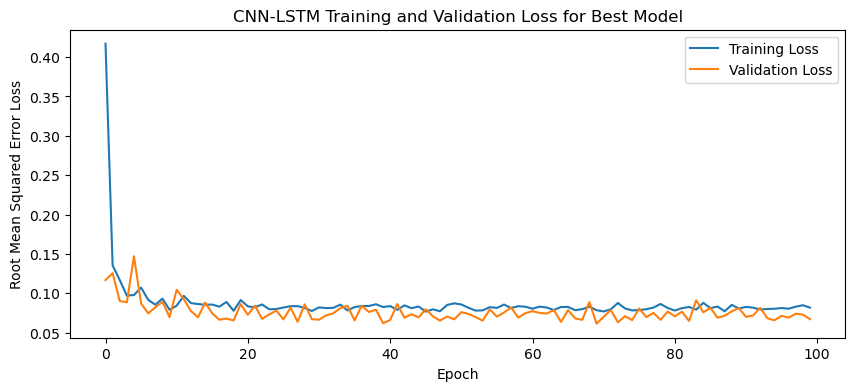

1/1 - 2s - loss: 0.0841 - 2s/epoch - 2s/step
Test Loss: 0.0841030701994896
Fold 4:
Epoch 1/100
20/20 [==============================] - 12s 259ms/step - loss: 0.4211 - val_loss: 0.1797
Epoch 2/100
20/20 [==============================] - 1s 51ms/step - loss: 0.1722 - val_loss: 0.1513
Epoch 3/100
20/20 [==============================] - 1s 56ms/step - loss: 0.1469 - val_loss: 0.1375
Epoch 4/100
20/20 [==============================] - 1s 52ms/step - loss: 0.1658 - val_loss: 0.1227
Epoch 5/100
20/20 [==============================] - 1s 63ms/step - loss: 0.1416 - val_loss: 0.1225
Epoch 6/100
20/20 [==============================] - 1s 64ms/step - loss: 0.1432 - val_loss: 0.0905
Epoch 7/100
20/20 [==============================] - 1s 73ms/step - loss: 0.1344 - val_loss: 0.1003
Epoch 8/100
20/20 [==============================] - 1s 70ms/step - loss: 0.1261 - val_loss: 0.1128
Epoch 9/100
20/20 [==============================] - 3s 159ms/step - loss: 0.1214 - val_loss: 0.0802
Epoch 10/100
2

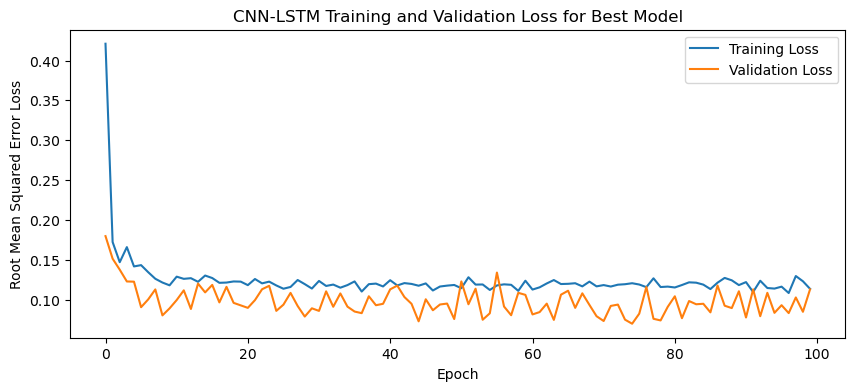

1/1 - 2s - loss: 0.1291 - 2s/epoch - 2s/step
Test Loss: 0.1291092485189438
Fold 5:
Epoch 1/100
19/19 [==============================] - 12s 207ms/step - loss: 0.4085 - val_loss: 0.1864
Epoch 2/100
19/19 [==============================] - 2s 82ms/step - loss: 0.1613 - val_loss: 0.2105
Epoch 3/100
19/19 [==============================] - 1s 77ms/step - loss: 0.1557 - val_loss: 0.1191
Epoch 4/100
19/19 [==============================] - 2s 88ms/step - loss: 0.1273 - val_loss: 0.1162
Epoch 5/100
19/19 [==============================] - 2s 93ms/step - loss: 0.1199 - val_loss: 0.1228
Epoch 6/100
19/19 [==============================] - 2s 115ms/step - loss: 0.1154 - val_loss: 0.0831
Epoch 7/100
19/19 [==============================] - 2s 82ms/step - loss: 0.1114 - val_loss: 0.1283
Epoch 8/100
19/19 [==============================] - 2s 95ms/step - loss: 0.1177 - val_loss: 0.1142
Epoch 9/100
19/19 [==============================] - 2s 92ms/step - loss: 0.0997 - val_loss: 0.0919
Epoch 10/100
1

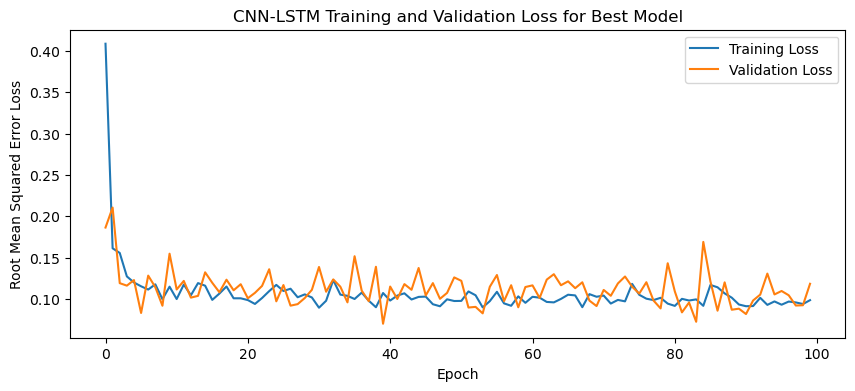

1/1 - 3s - loss: 0.0891 - 3s/epoch - 3s/step
Test Loss: 0.08913616836071014


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

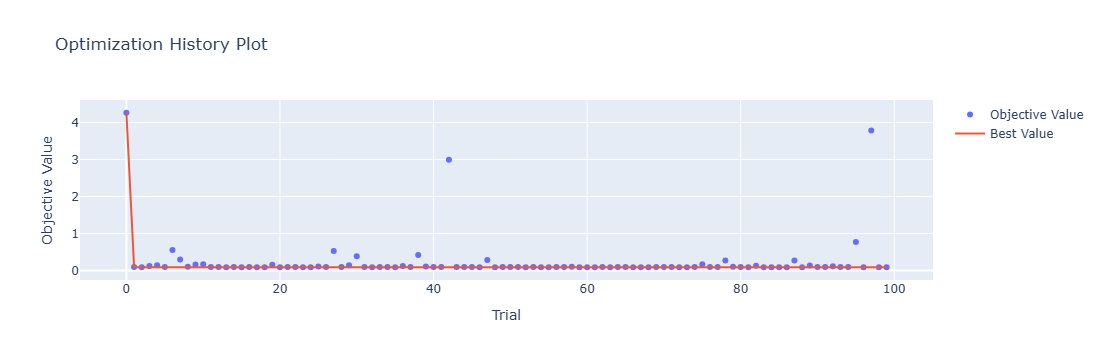

In [4]:
optuna.visualization.plot_optimization_history(study)

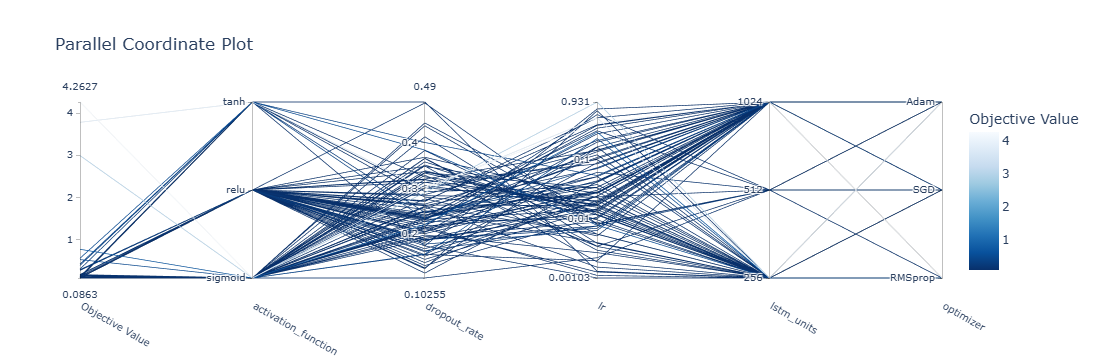

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

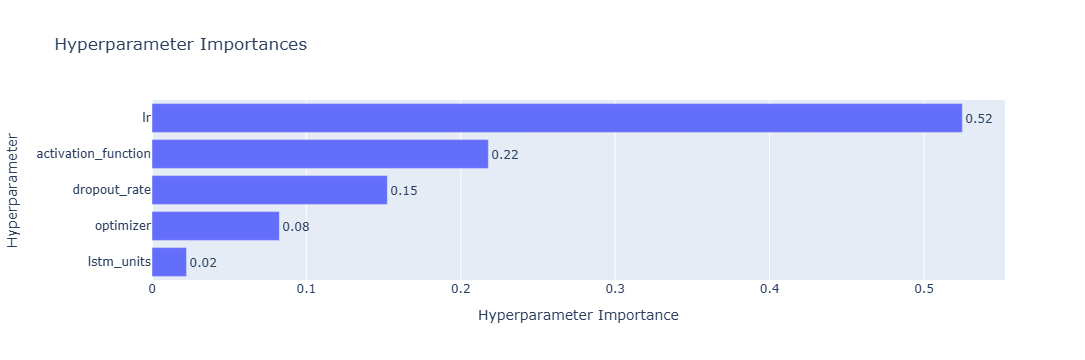

In [6]:
optuna.visualization.plot_param_importances(study)

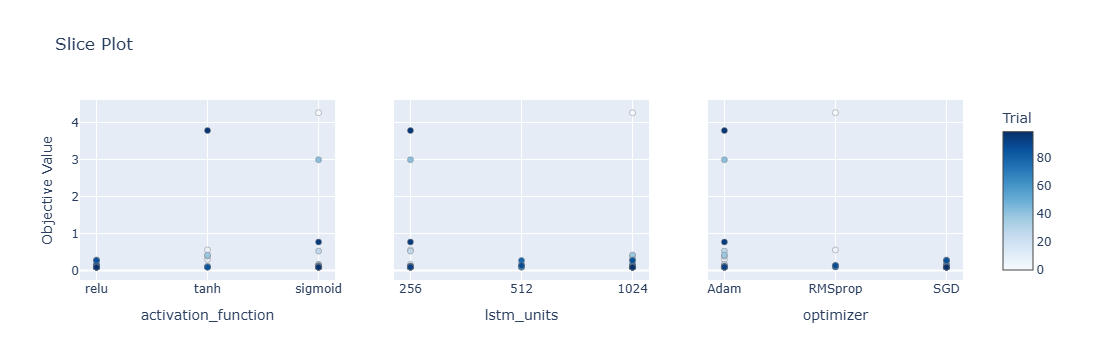

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

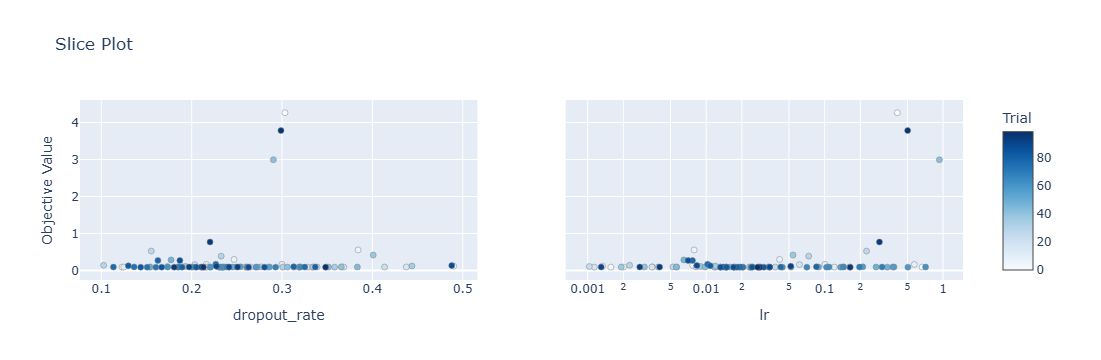

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[12.82 12.33 12.14 11.9  12.75 12.05 11.96 11.88 11.66 11.6  11.21 11.85
  11.29 12.12 12.23 11.95 11.91 12.96 13.05 13.43 12.59 12.54 12.66 12.47
  12.18 12.49 13.25]
 [10.07  9.17  8.73  9.1   9.64  9.62  9.38  9.31  8.9   8.65  8.67  9.09
   8.97  9.33  9.58  9.53  9.17 10.25  9.66 10.33 10.45 10.26 10.47 10.03
   9.51  9.7  10.33]]
Epoch 1/100
19/19 [==============================] - 24s 282ms/step - loss: 0.3876 - accuracy: 0.2632 - mae: 0.3146 - rmse: 0.3876 - mape: 75.9531 - pearson: 0.1574 - val_loss: 0.1868 - val_accuracy: 0.3333 - val_mae: 0.1339 - val_rmse: 0.1868 - val_mape: 31.7369 - val_pearson: 0.2146
Epoch 2/100
19/19 [==============================] - 0s 22ms/step - loss: 0.1350 - accuracy: 0.1579 - mae: 0.1082 - rmse: 0.1350 - mape: 26.5723 - pearson: 0.1368 - val_loss: 0.1368 - val_accuracy: 0.3333 - val_mae: 0.1181 - val_rmse: 0.1368 - val_mape: 28.8451 - val_pearson: 0.2200
Epoch 3/100
19/19 [==============================] - 0s 24ms/step - loss: 0.1356 - accuracy

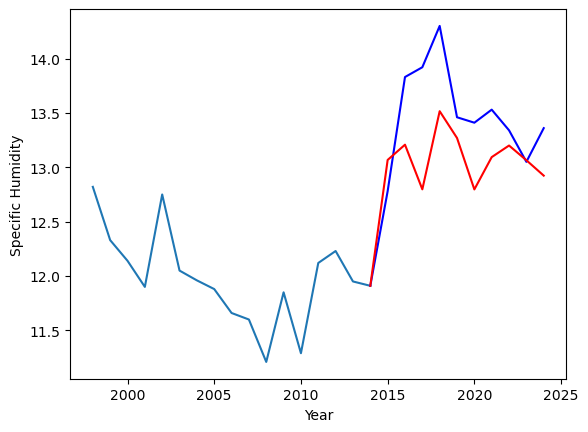

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
9.71		10.32		0.61
10.79		10.46		-0.33
10.20		10.05		-0.15
10.87		10.77		-0.10
10.99		10.52		-0.47
10.80		10.05		-0.75
11.01		10.34		-0.67
10.57		10.45		-0.12
10.05		10.31		0.26
10.24		10.17		-0.07


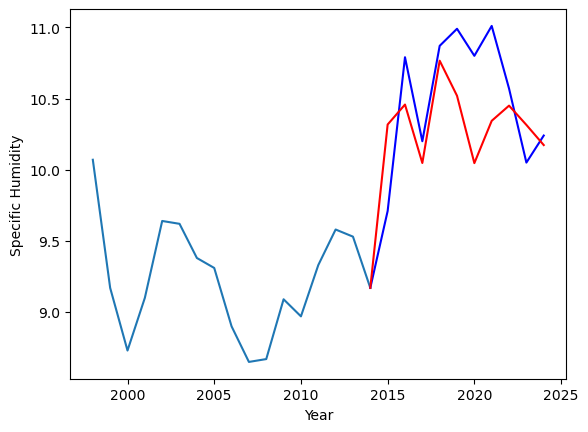

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   12.78   13.06749
1                1    9.71   10.31749


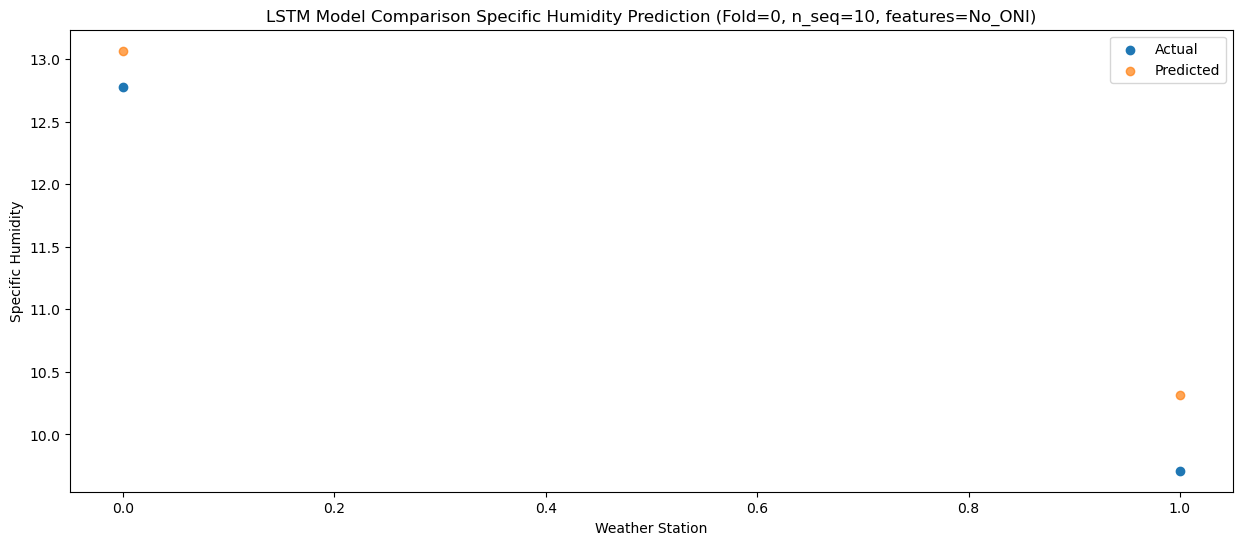

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   13.83  13.207718
1                1   10.79  10.457718


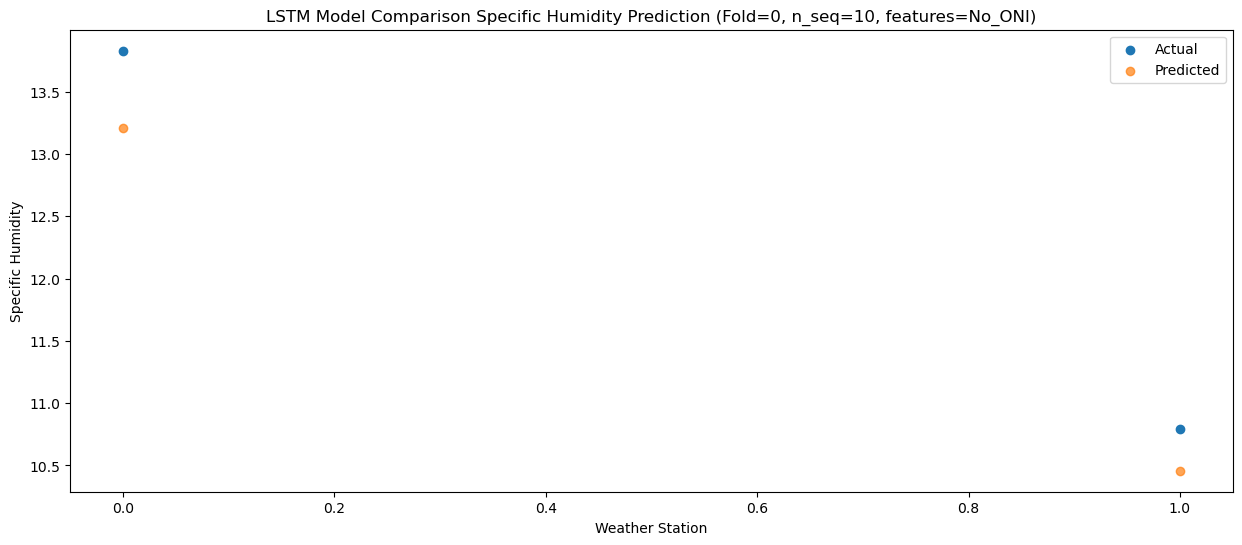

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   13.92   12.79719
1                1   10.20   10.04719


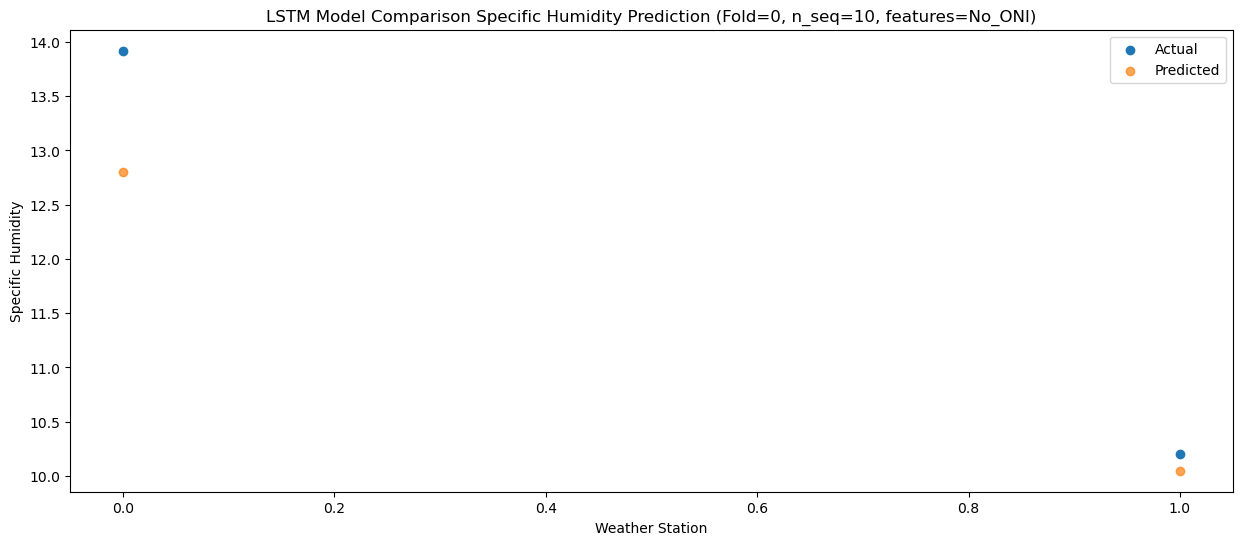

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   14.30  13.515736
1                1   10.87  10.765736


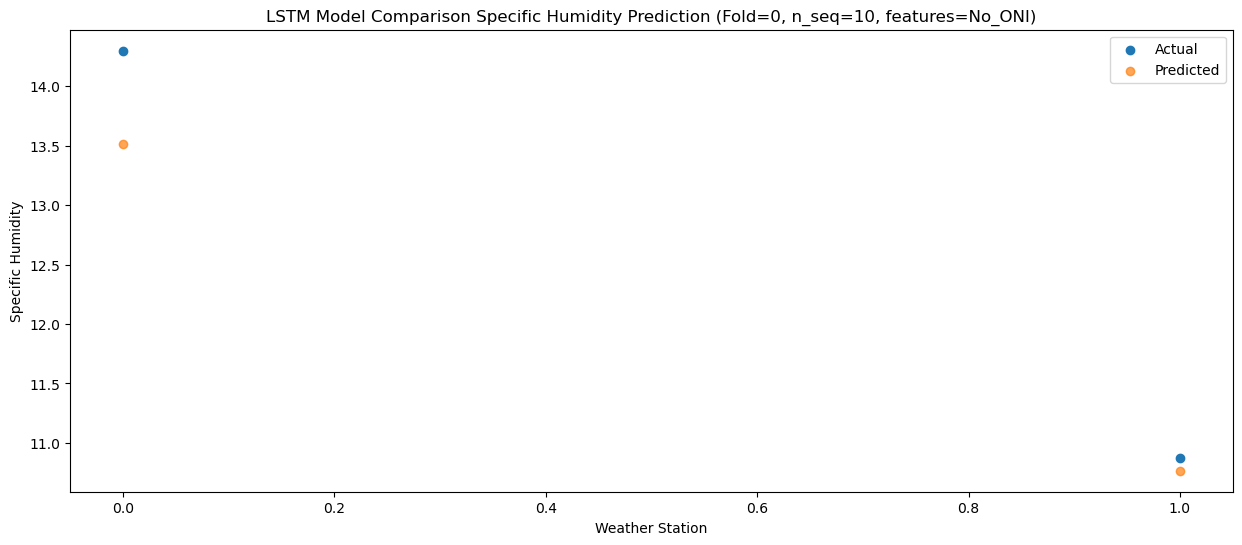

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   13.46  13.269363
1                1   10.99  10.519363


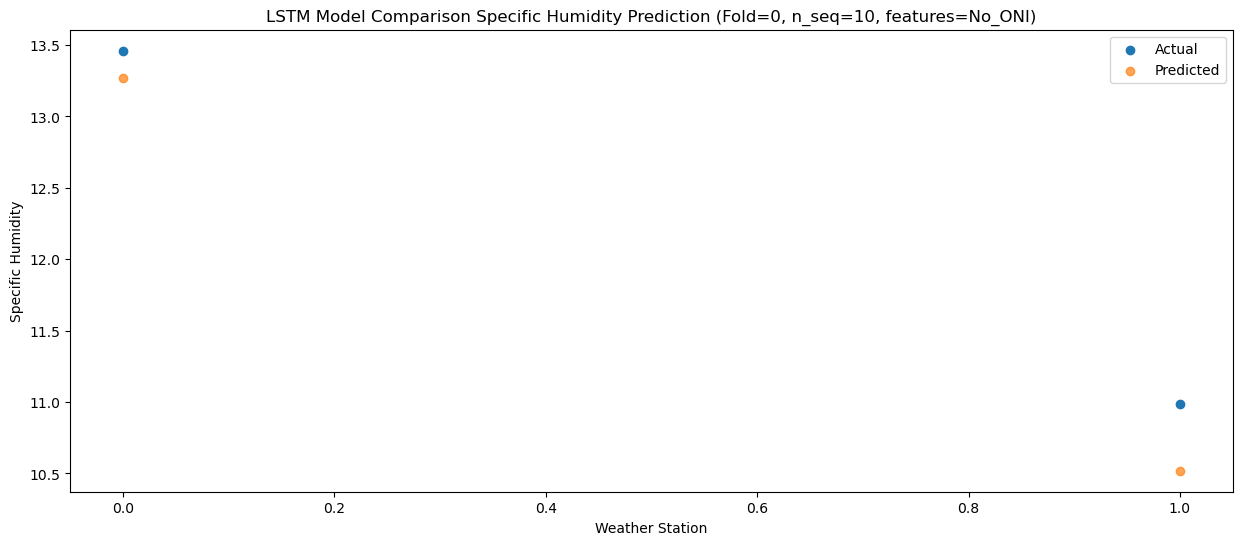

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   13.41  12.796327
1                1   10.80  10.046327


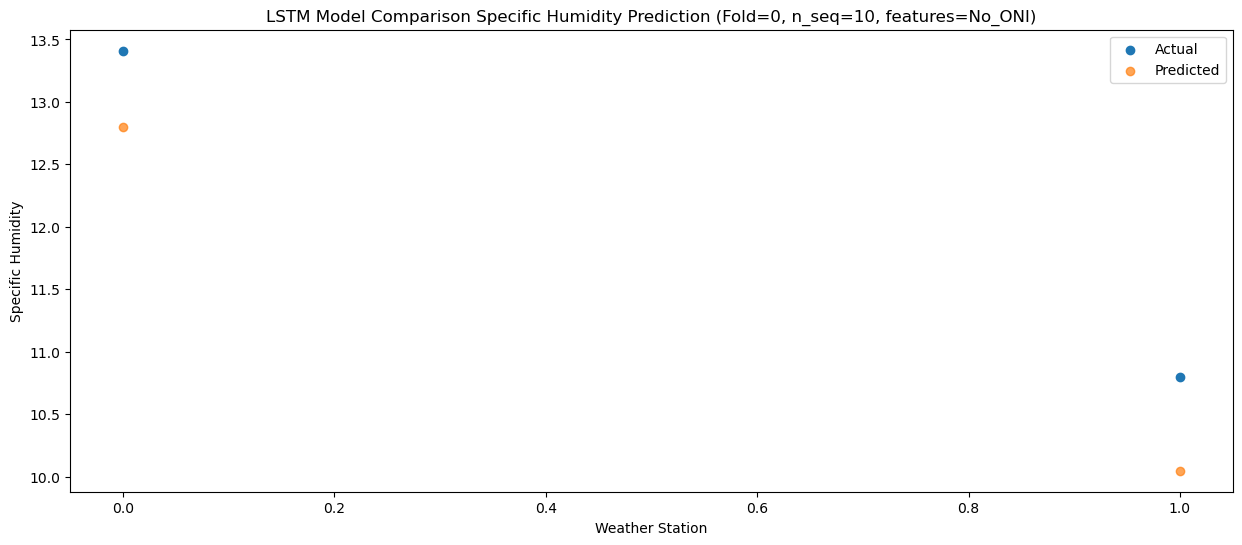

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   13.53   13.09341
1                1   11.01   10.34341


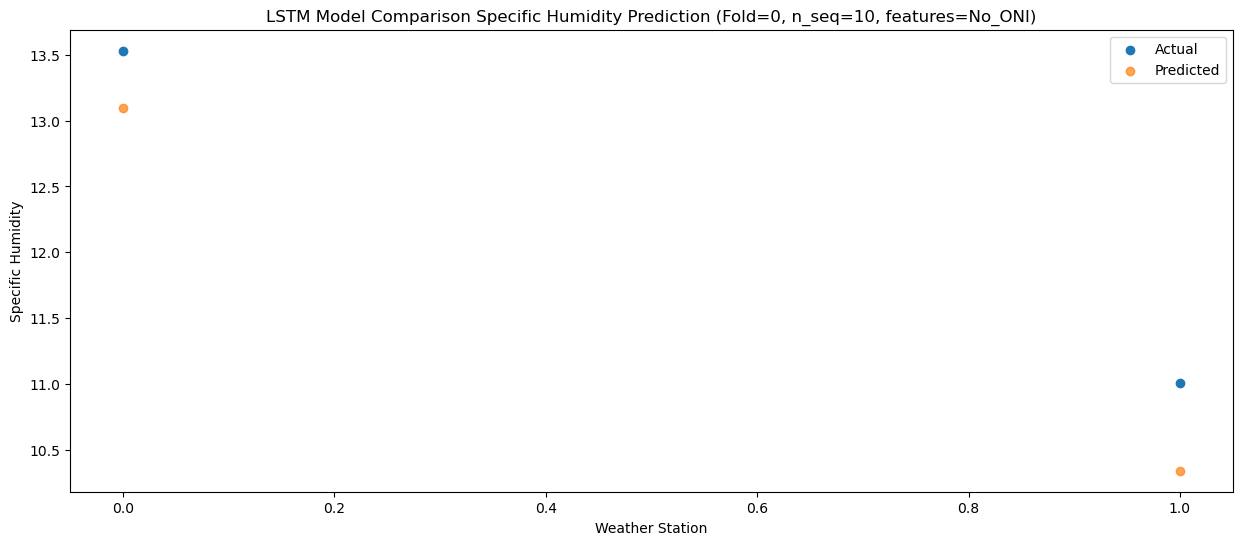

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   13.34  13.200087
1                1   10.57  10.450087


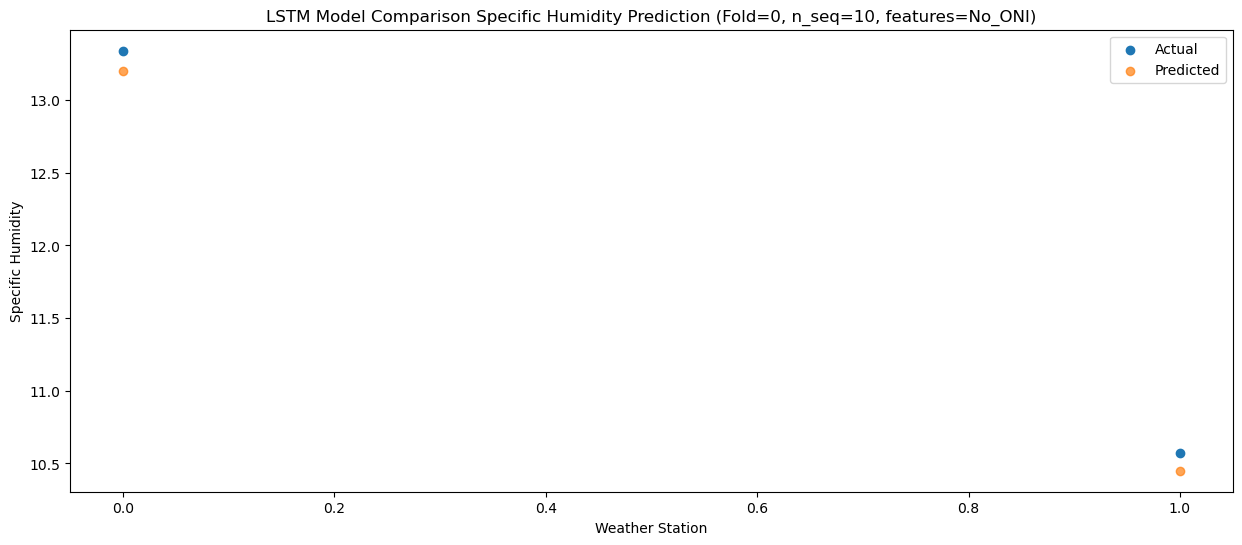

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   13.05  13.064735
1                1   10.05  10.314735


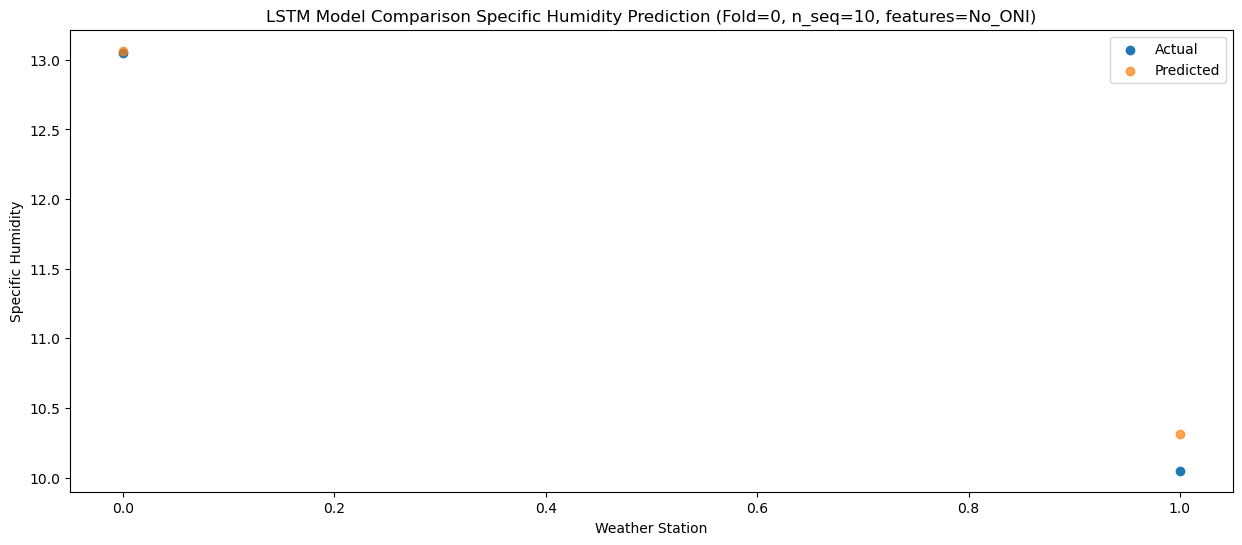

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   13.36  12.923165
1                1   10.24  10.173165


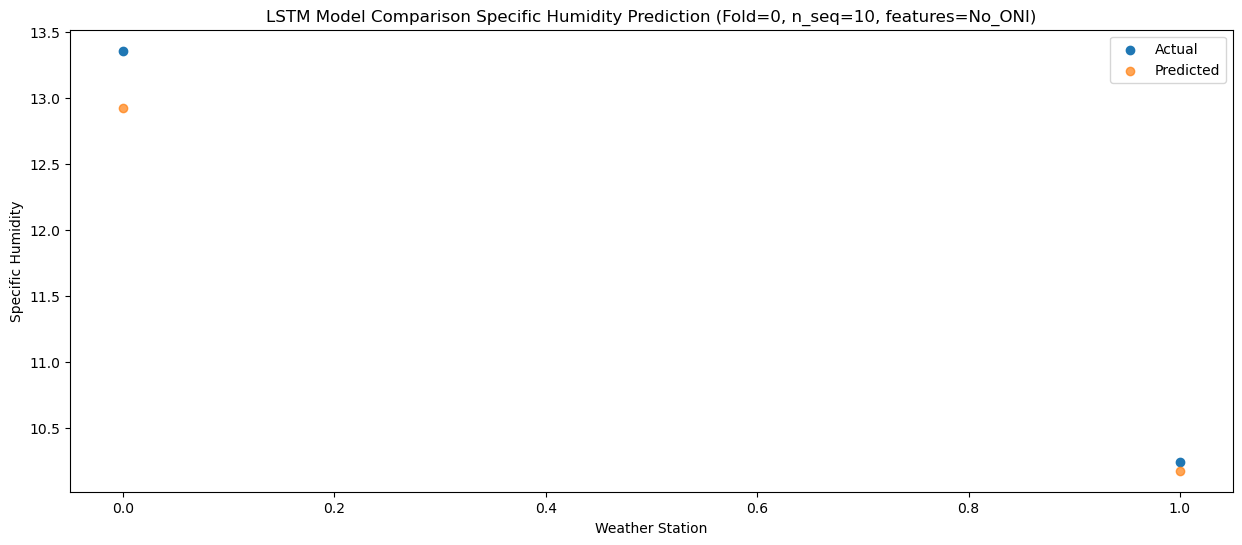

f, t:
[[12.78  9.71]
 [13.83 10.79]
 [13.92 10.2 ]
 [14.3  10.87]
 [13.46 10.99]
 [13.41 10.8 ]
 [13.53 11.01]
 [13.34 10.57]
 [13.05 10.05]
 [13.36 10.24]]
[[13.06749002 10.31749002]
 [13.2077176  10.4577176 ]
 [12.79718972 10.04718972]
 [13.51573575 10.76573575]
 [13.26936277 10.51936277]
 [12.7963272  10.0463272 ]
 [13.09341013 10.34341013]
 [13.20008732 10.45008732]
 [13.0647349  10.3147349 ]
 [12.92316475 10.17316475]]
Year at t+1:
t+1 SKRMSE: 0.475234
t+1 KRMSE: 0.475234
t+1 MAE: 0.447490
t+1 SKMAPE: 0.042529
t+1 R2_SCORE: 0.904149
t+1 KMAPE: 0.042529
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 11.245000
Year at t+2:
t+2 SKRMSE: 0.498822
t+2 KRMSE: 0.498822
t+2 MAE: 0.477282
t+2 SKMAPE: 0.037895
t+2 R2_SCORE: 0.892303
t+2 KMAPE: 0.037895
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 12.310000
Year at t+3:
t+3 SKRMSE: 0.801266
t+3 KRMSE: 0.801266
t+3 MAE: 0.637810
t+3 SKMAPE: 0.047822
t+3 R2_SCORE: 0.814422
t+3 KMAPE: 0.047822
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 12.060000
Year at 

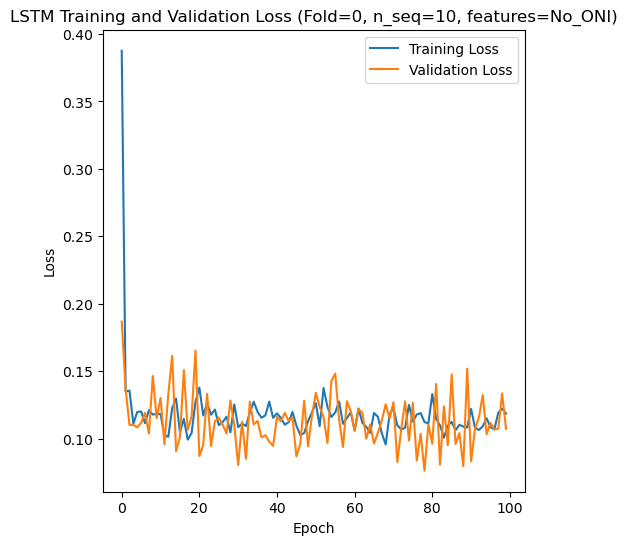

[[11.47 10.69 10.49 10.89 11.27 10.87 11.1  11.03 10.18 10.34 10.24 10.68
  10.6  10.94 10.76 10.47 10.42 11.26 10.81 11.26 11.81 11.14 11.5  10.83
  10.88 10.74 11.48]
 [ 7.63  7.36  7.16  7.53  7.72  7.87  8.49  7.73  6.89  8.03  6.62  6.93
   7.69  5.78  7.04  6.89  7.21  8.34  8.32  7.95  7.79  7.82  7.08  7.52
   6.95  7.1   7.65]]
Epoch 1/100
19/19 [==============================] - 9s 237ms/step - loss: 0.4336 - accuracy: 0.0526 - mae: 0.3656 - rmse: 0.4336 - mape: 85.9409 - pearson: 0.1180 - val_loss: 0.0980 - val_accuracy: 0.0000e+00 - val_mae: 0.0850 - val_rmse: 0.0980 - val_mape: 20.2870 - val_pearson: 0.1481
Epoch 2/100
19/19 [==============================] - 0s 21ms/step - loss: 0.1247 - accuracy: 0.2105 - mae: 0.1037 - rmse: 0.1247 - mape: 24.6961 - pearson: 0.1349 - val_loss: 0.0975 - val_accuracy: 0.6667 - val_mae: 0.0824 - val_rmse: 0.0975 - val_mape: 19.7740 - val_pearson: 0.2548
Epoch 3/100
19/19 [==============================] - 0s 23ms/step - loss: 0.1097 - accur

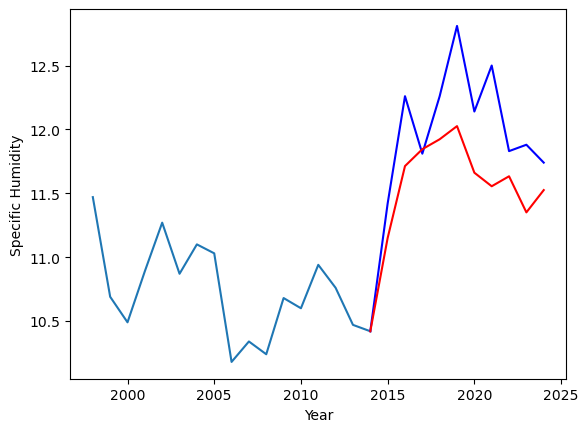

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.95		7.31		-0.64
9.08		7.87		-1.21
9.06		8.01		-1.05
8.69		8.08		-0.61
8.53		8.19		-0.34
8.56		7.82		-0.74
7.82		7.72		-0.10
8.26		7.79		-0.47
7.69		7.51		-0.18
7.84		7.69		-0.15


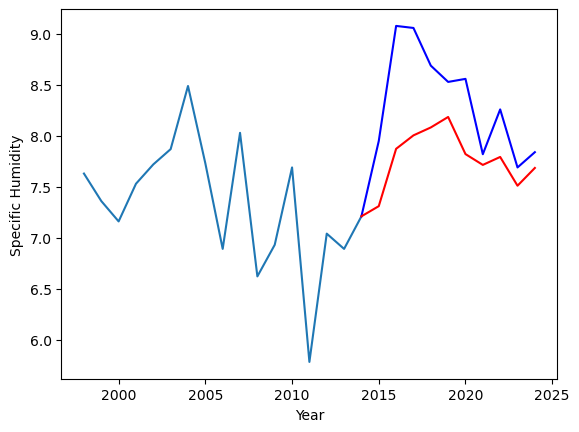

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.42   11.14984
1                1    7.95    7.30984


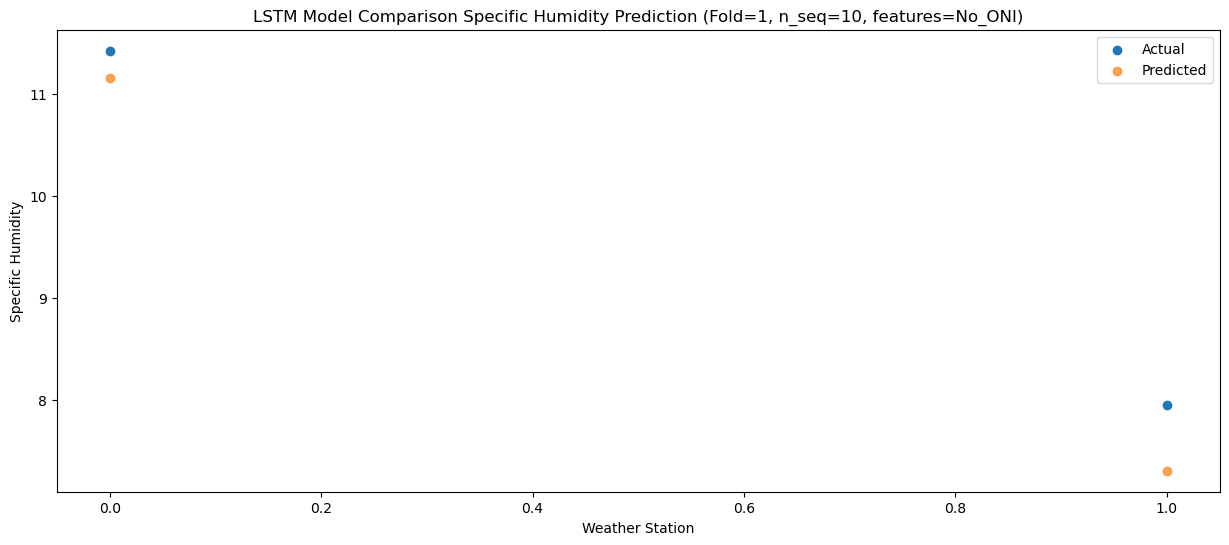

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   12.26  11.712966
1                1    9.08   7.872966


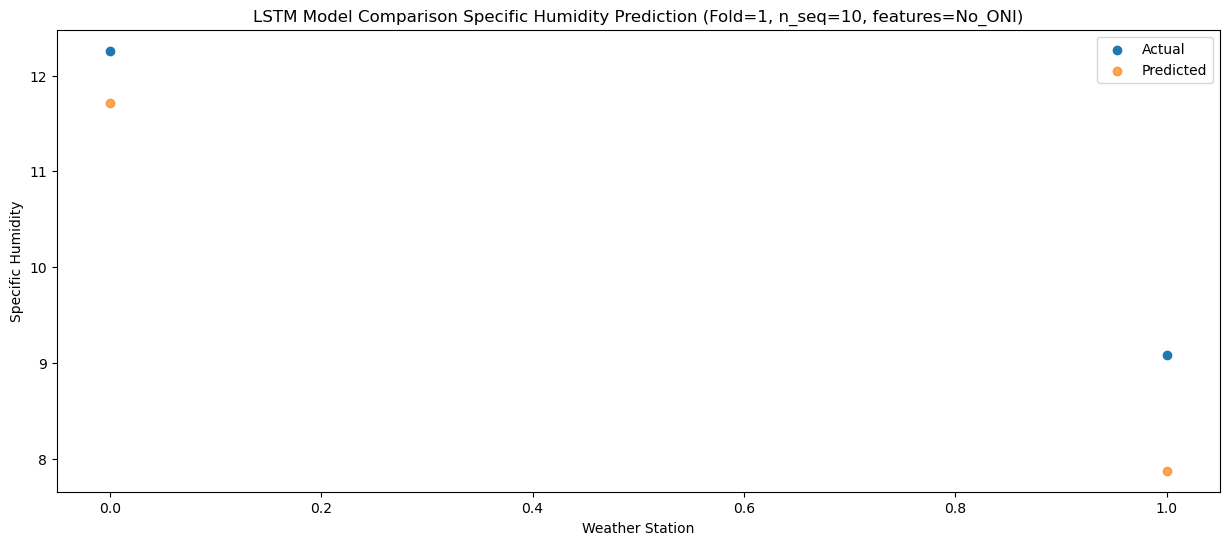

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   11.81   11.84508
1                1    9.06    8.00508


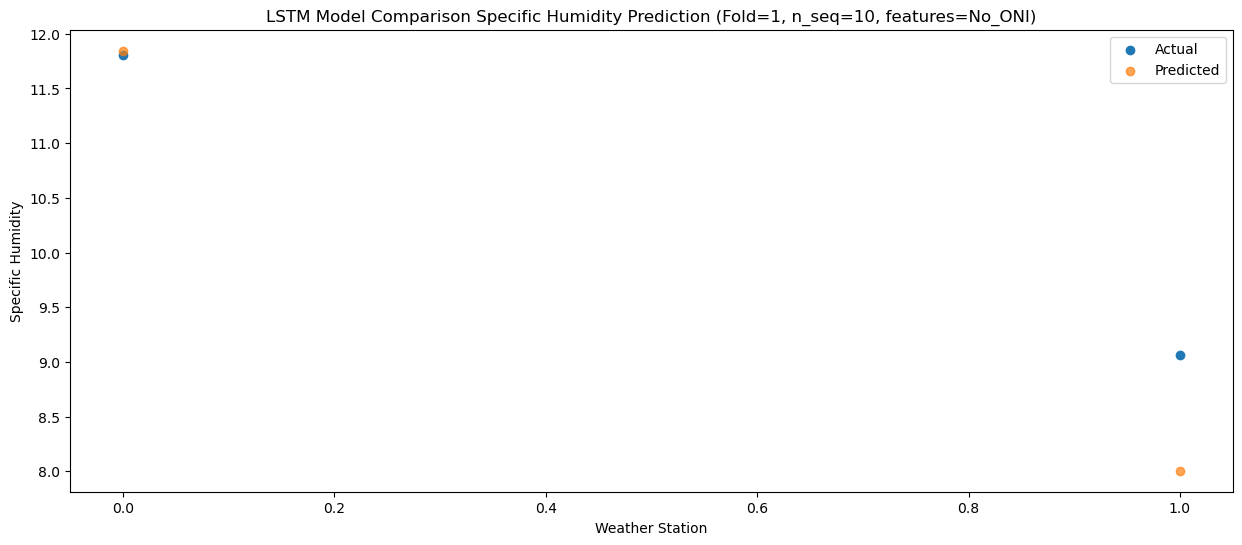

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   12.26  11.922859
1                1    8.69   8.082859


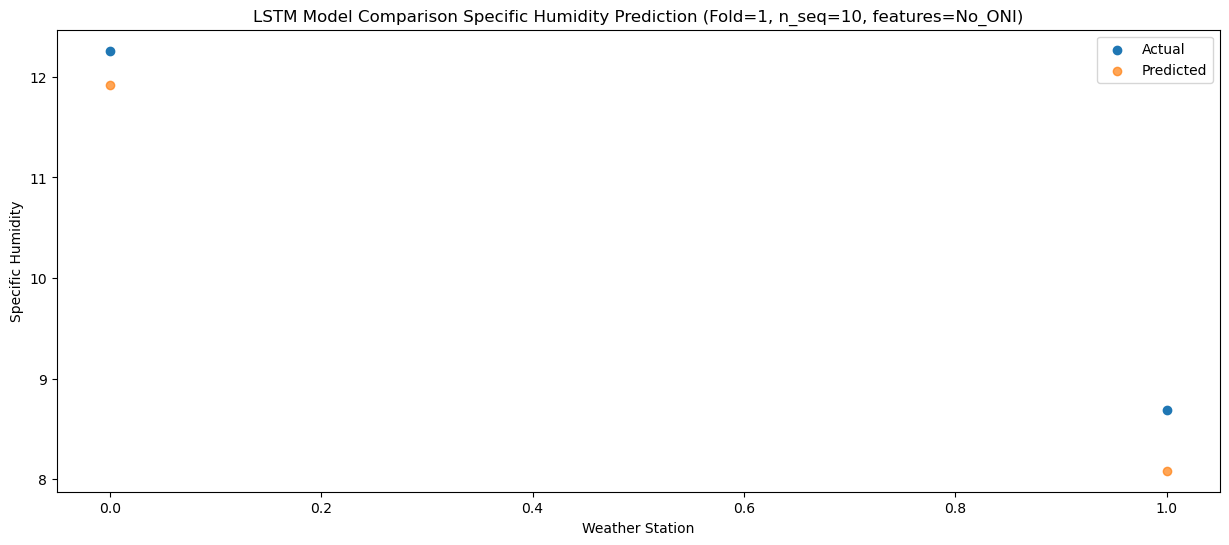

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   12.81  12.025785
1                1    8.53   8.185785


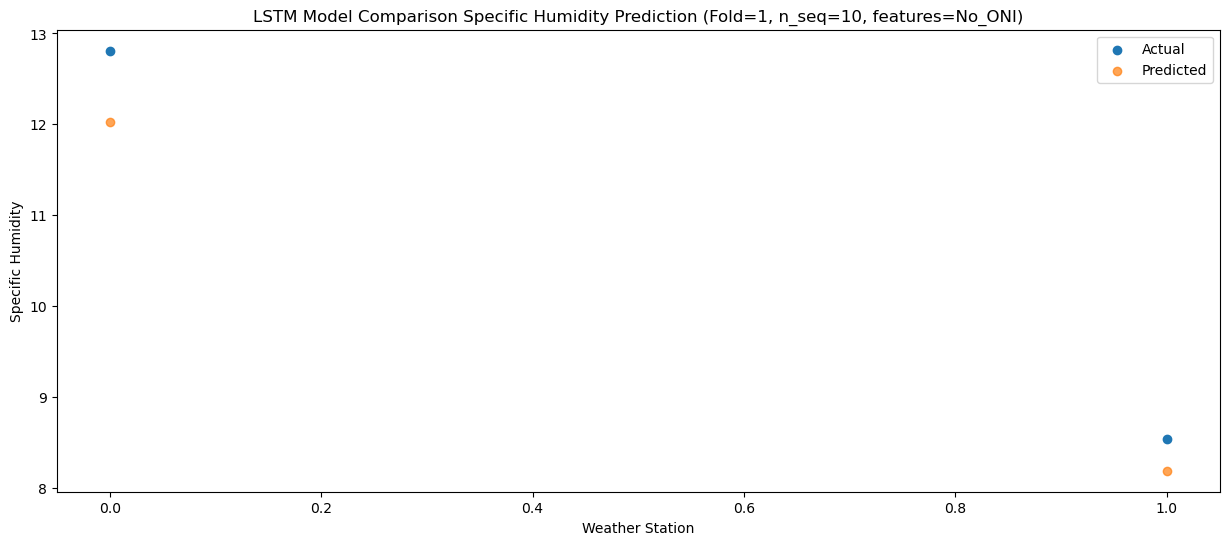

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   12.14  11.661154
1                1    8.56   7.821154


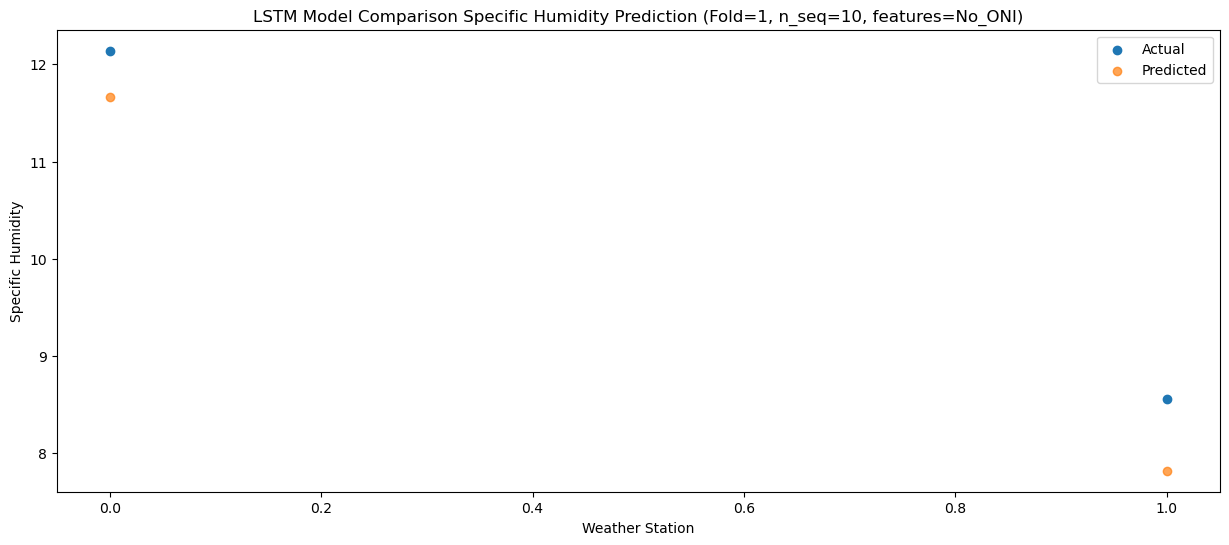

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   12.50     11.555
1                1    7.82      7.715


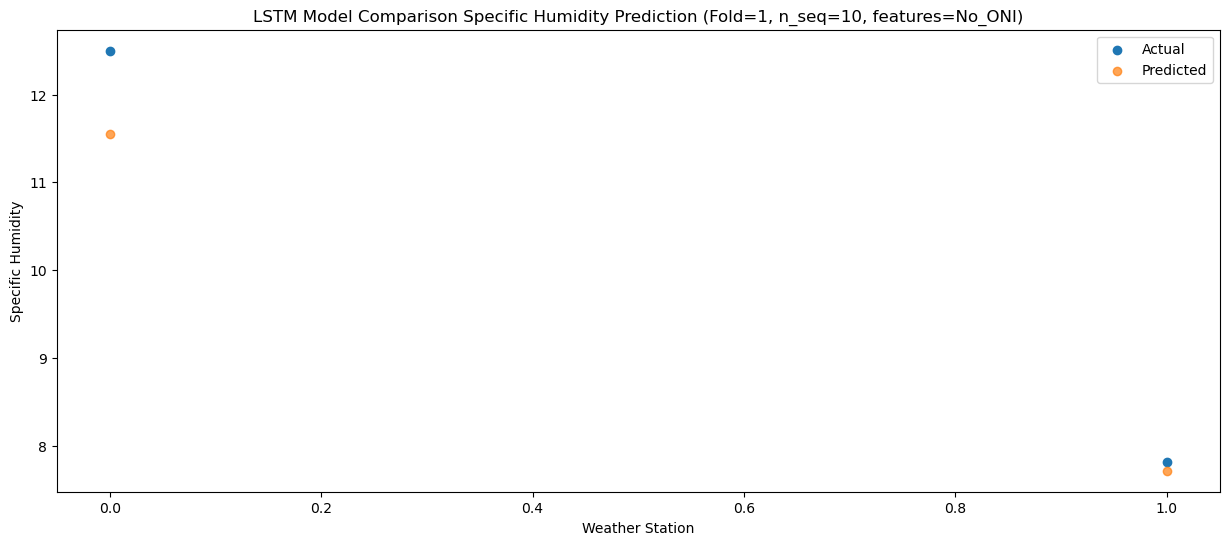

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   11.83  11.633104
1                1    8.26   7.793104


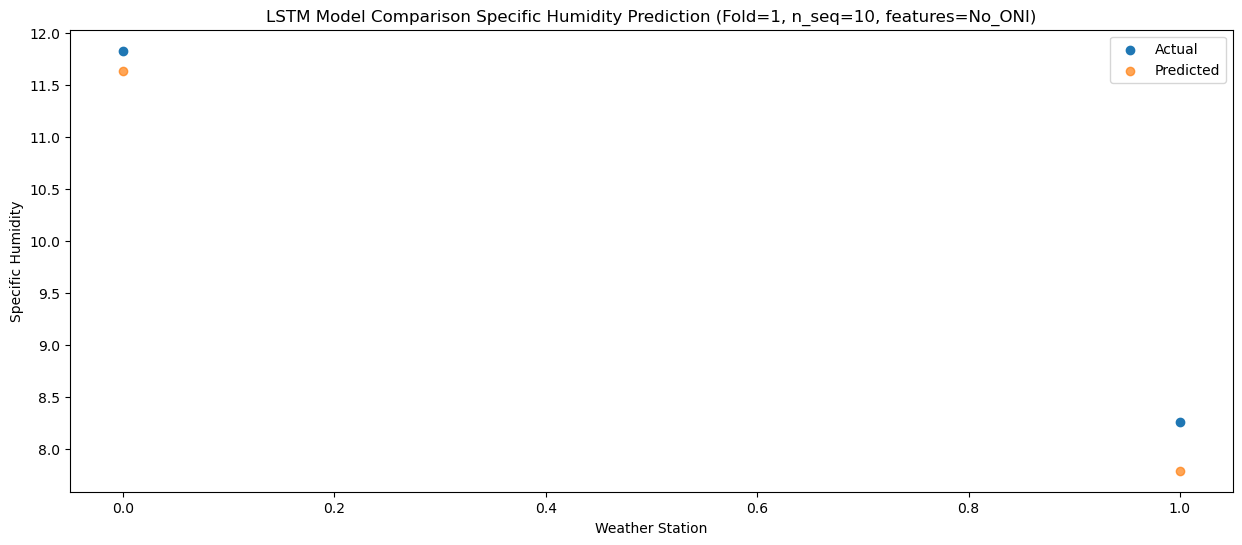

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   11.88  11.350515
1                1    7.69   7.510515


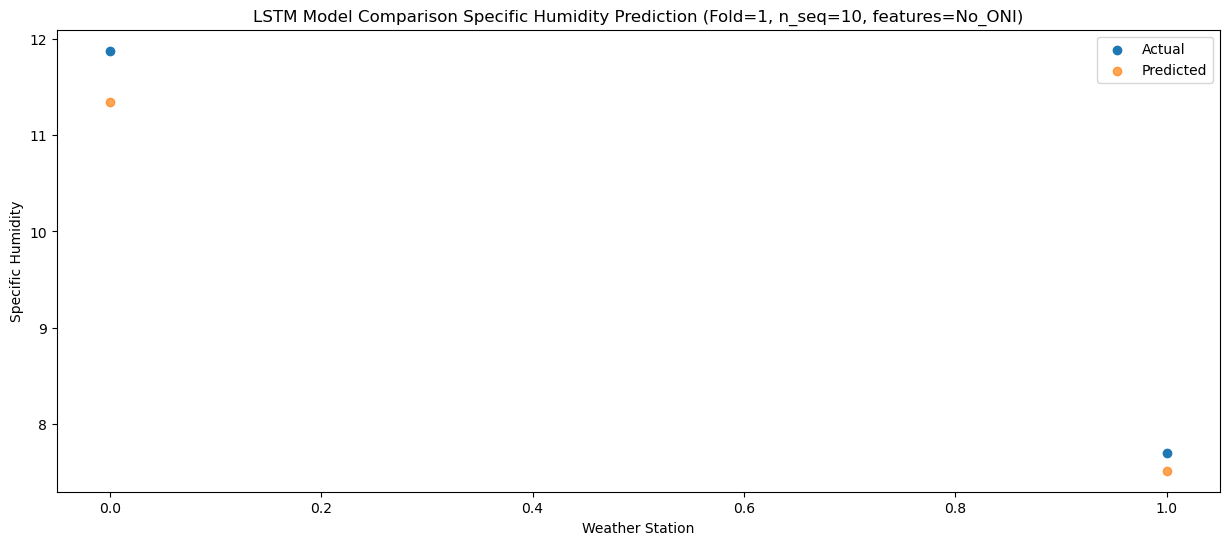

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   11.74  11.525077
1                1    7.84   7.685077


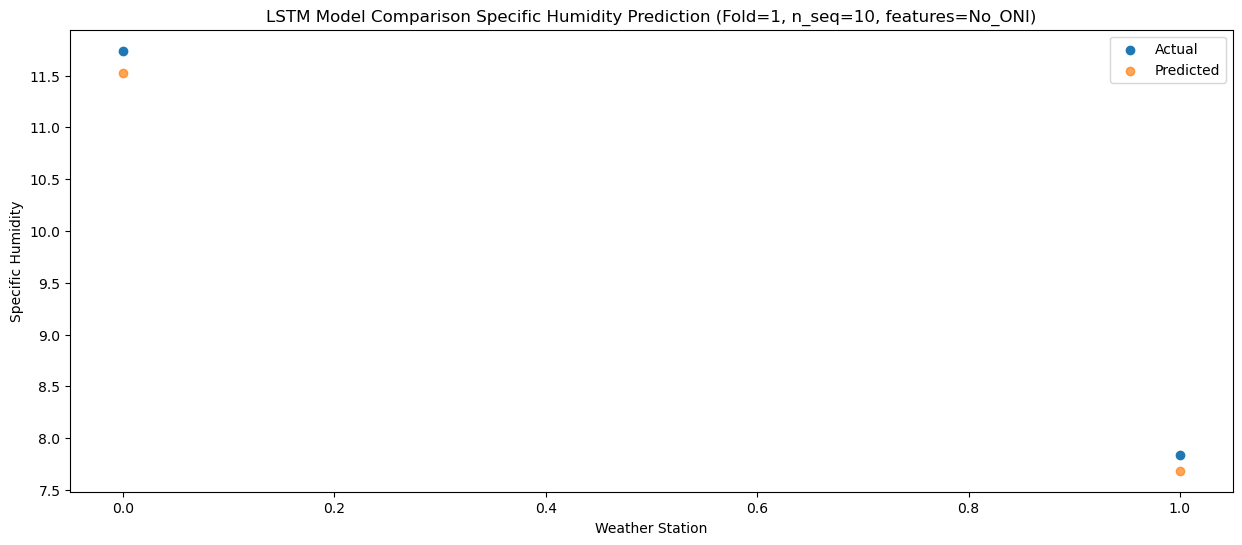

f, t:
[[11.42  7.95]
 [12.26  9.08]
 [11.81  9.06]
 [12.26  8.69]
 [12.81  8.53]
 [12.14  8.56]
 [12.5   7.82]
 [11.83  8.26]
 [11.88  7.69]
 [11.74  7.84]]
[[11.14983952  7.30983952]
 [11.71296632  7.87296632]
 [11.84508014  8.00508014]
 [11.9228591   8.0828591 ]
 [12.02578451  8.18578451]
 [11.66115369  7.82115369]
 [11.55500014  7.71500014]
 [11.63310425  7.79310425]
 [11.35051499  7.51051499]
 [11.52507708  7.68507708]]
Year at t+1:
t+1 SKRMSE: 0.491321
t+1 KRMSE: 0.491321
t+1 MAE: 0.455160
t+1 SKMAPE: 0.052090
t+1 R2_SCORE: 0.919808
t+1 KMAPE: 0.052090
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.685000
Year at t+2:
t+2 SKRMSE: 0.937064
t+2 KRMSE: 0.937064
t+2 MAE: 0.877034
t+2 SKMAPE: 0.088776
t+2 R2_SCORE: 0.652669
t+2 KMAPE: 0.088776
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 10.670000
Year at t+3:
t+3 SKRMSE: 0.746353
t+3 KRMSE: 0.746353
t+3 MAE: 0.545000
t+3 SKMAPE: 0.059704
t+3 R2_SCORE: 0.705366
t+3 KMAPE: 0.059704
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 10.435000
Year at t

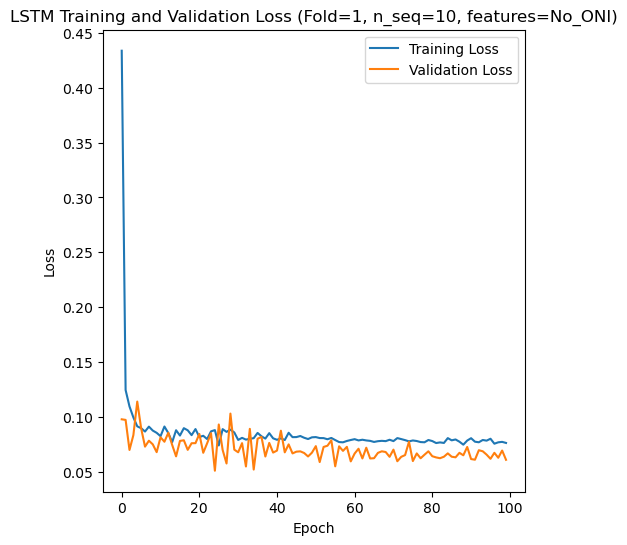

[[ 9.91  9.14  8.93  8.85  8.98  9.08  8.94  8.84  8.35  8.13  8.01  8.88
   8.79  8.86  9.22  8.7   8.51  9.48  9.05  9.73 10.13  9.86  9.33  8.92
   8.82  9.09  9.65]
 [ 8.49  7.33  7.71  7.76  7.77  7.75  7.45  7.41  7.43  7.25  7.05  7.35
   7.52  7.92  7.47  7.81  7.    7.75  8.3   8.25  8.35  7.7   7.52  7.59
   7.86  7.87  8.55]]
Epoch 1/100
19/19 [==============================] - 7s 80ms/step - loss: 0.4178 - accuracy: 0.2105 - mae: 0.3516 - rmse: 0.4178 - mape: 83.9636 - pearson: 0.1964 - val_loss: 0.1090 - val_accuracy: 0.0000e+00 - val_mae: 0.0876 - val_rmse: 0.1090 - val_mape: 20.8206 - val_pearson: 0.2473
Epoch 2/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1356 - accuracy: 0.2105 - mae: 0.1123 - rmse: 0.1356 - mape: 26.2647 - pearson: 0.1753 - val_loss: 0.1124 - val_accuracy: 0.0000e+00 - val_mae: 0.0882 - val_rmse: 0.1124 - val_mape: 21.2972 - val_pearson: 0.1392
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1062 - accu

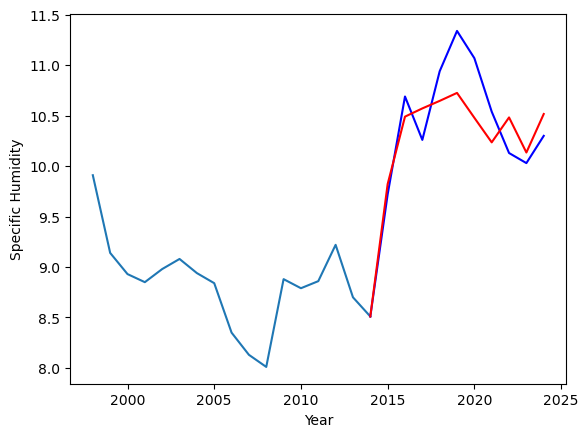

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.68		8.40		0.72
8.43		9.07		0.64
8.98		9.15		0.17
8.93		9.23		0.30
9.03		9.31		0.28
8.38		9.06		0.68
8.20		8.82		0.62
8.27		9.06		0.79
8.54		8.71		0.17
8.55		9.10		0.55


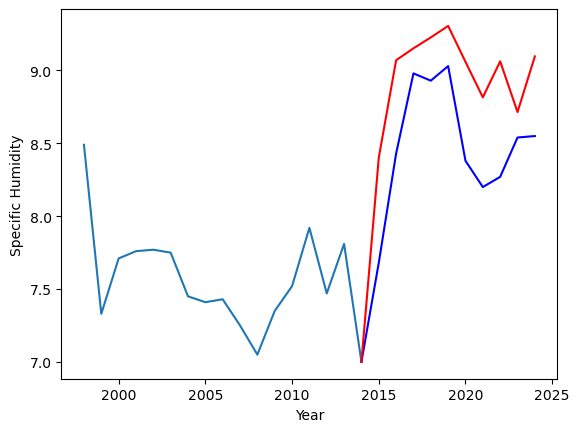

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    9.72   9.821684
1                1    7.68   8.401684


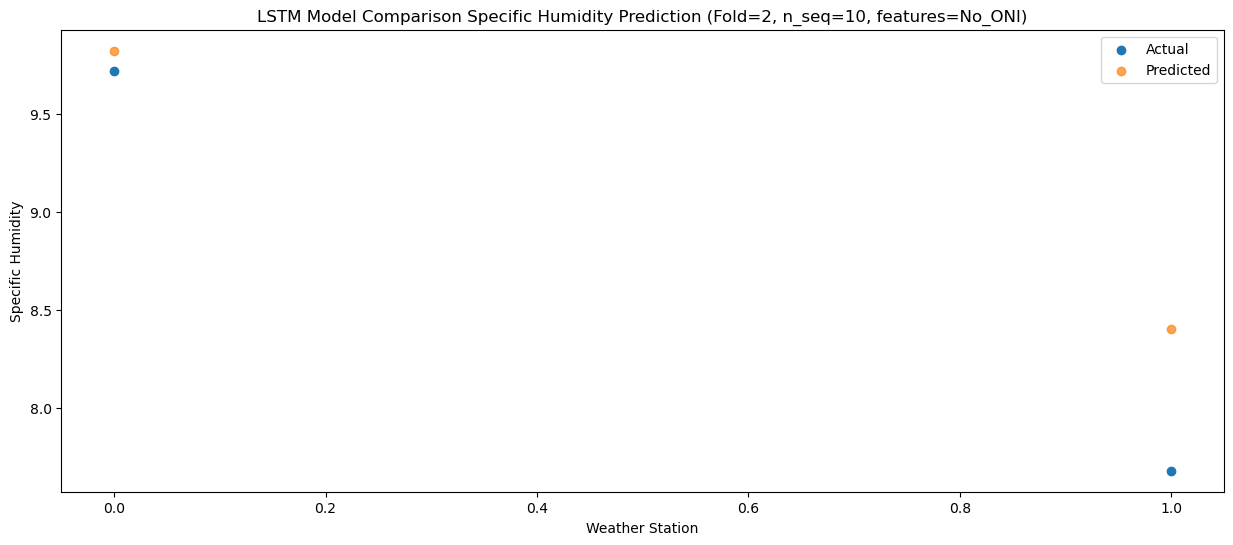

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   10.69  10.490466
1                1    8.43   9.070466


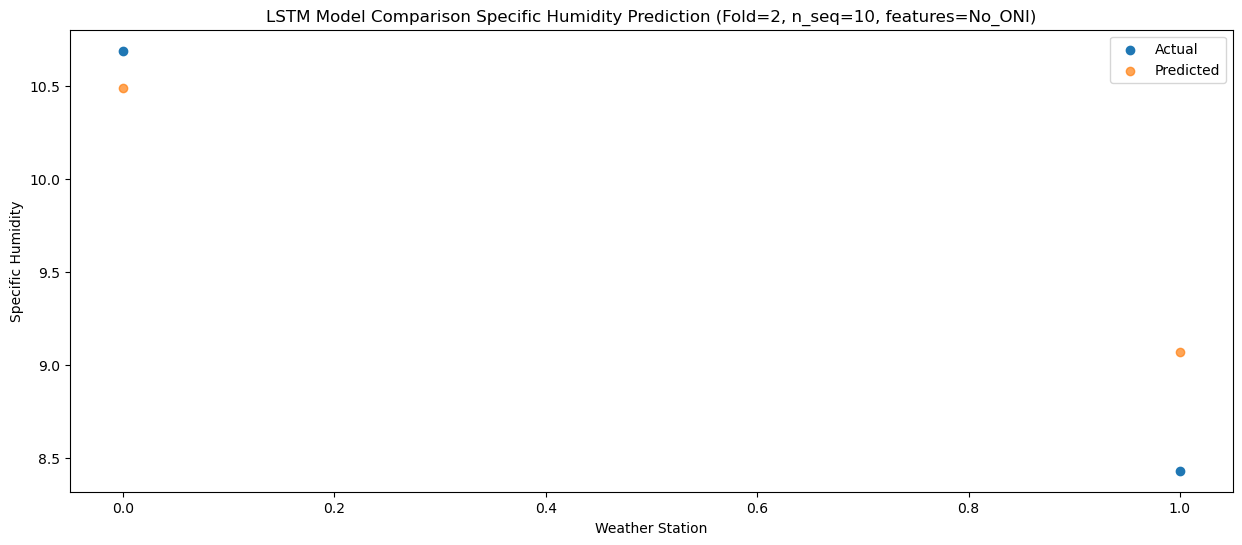

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   10.26  10.572039
1                1    8.98   9.152039


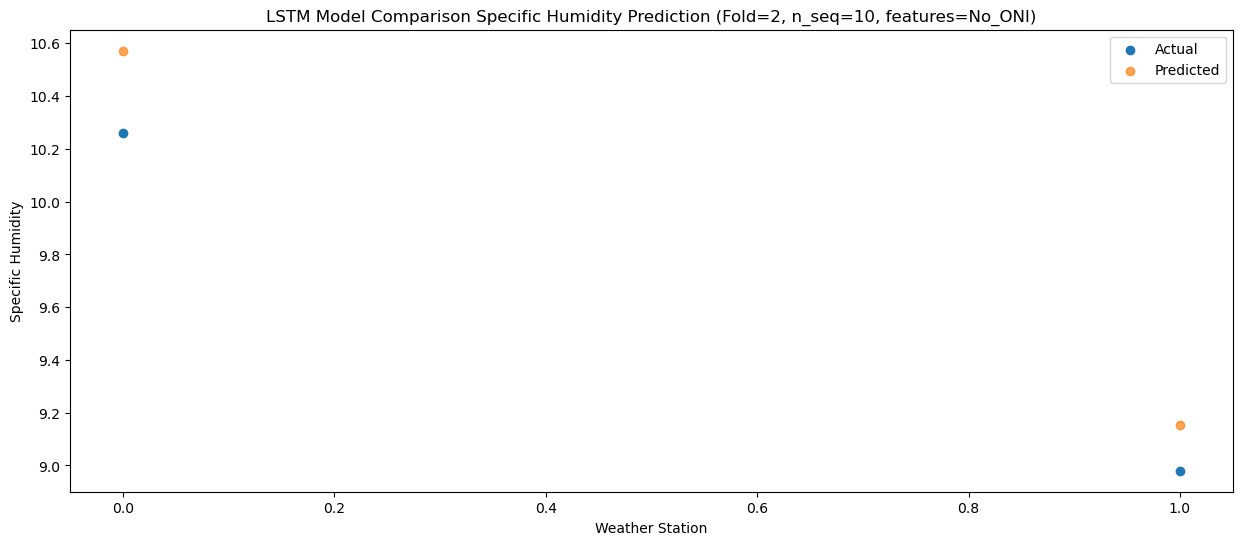

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   10.94  10.646682
1                1    8.93   9.226682


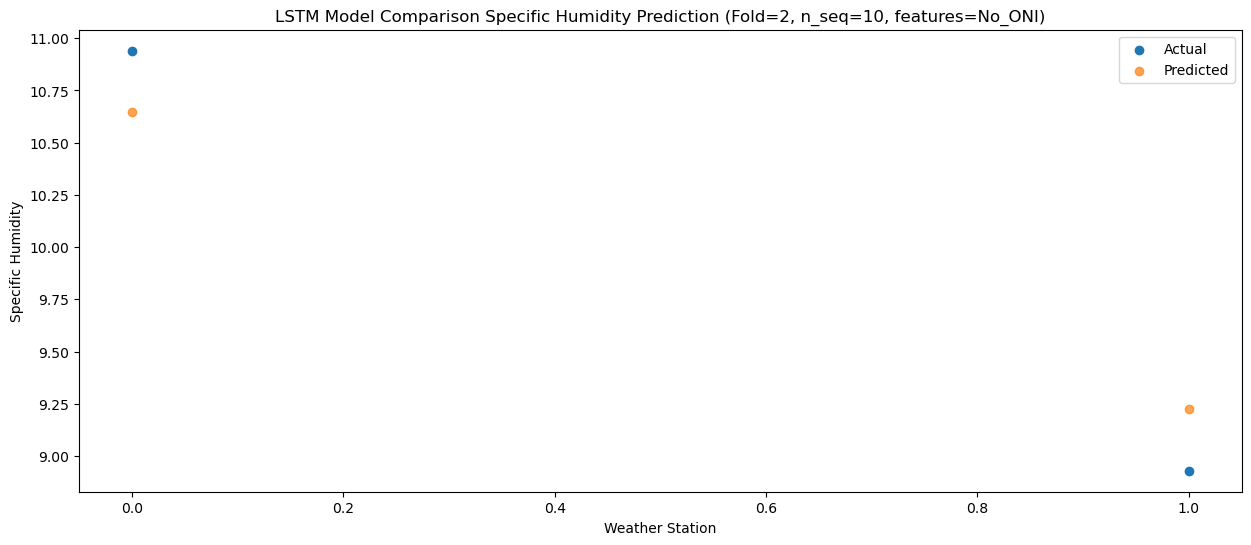

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   11.34   10.72573
1                1    9.03    9.30573


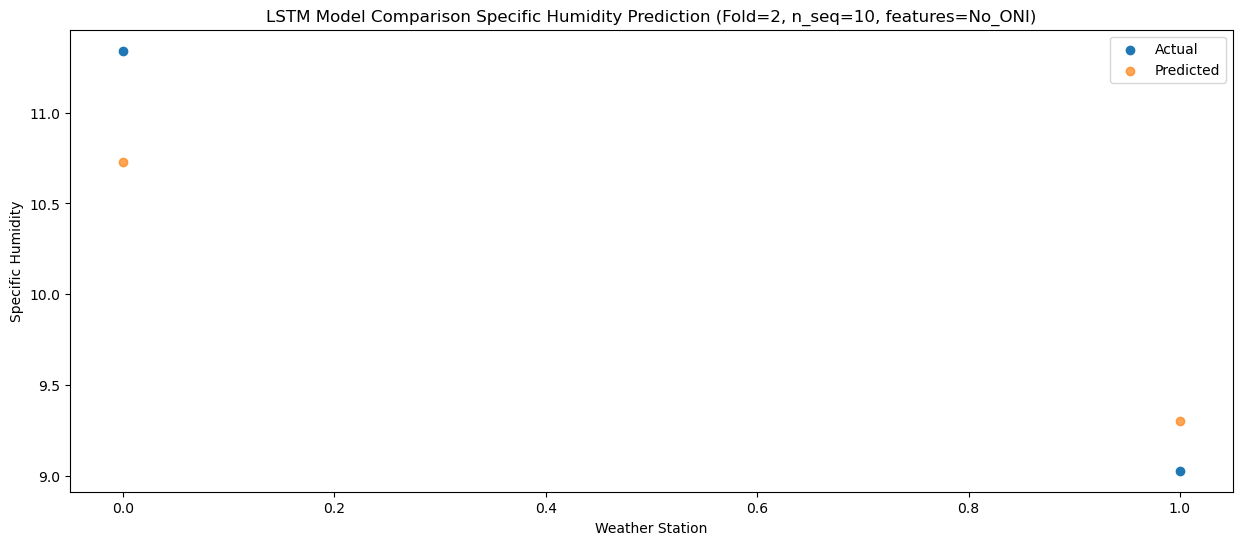

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   11.07  10.479128
1                1    8.38   9.059128


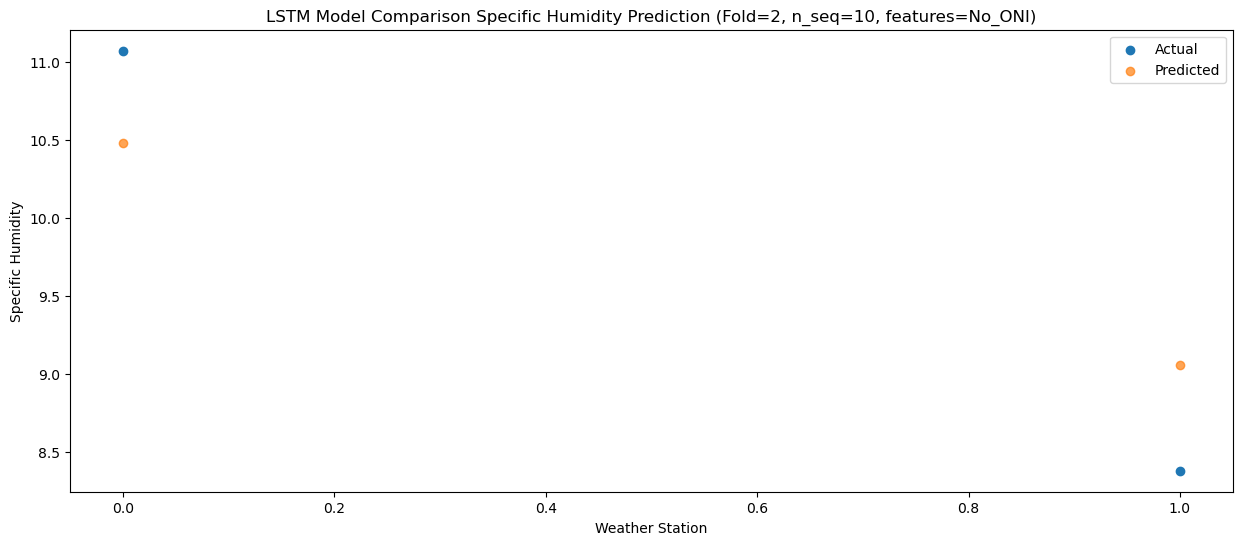

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   10.54  10.235607
1                1    8.20   8.815607


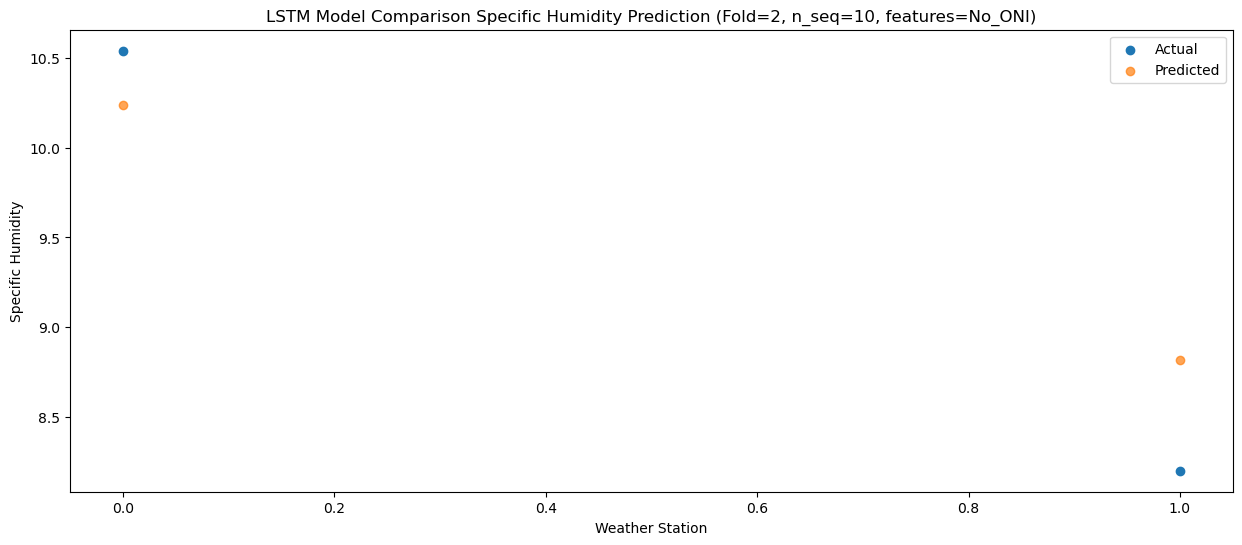

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   10.13  10.482618
1                1    8.27   9.062618


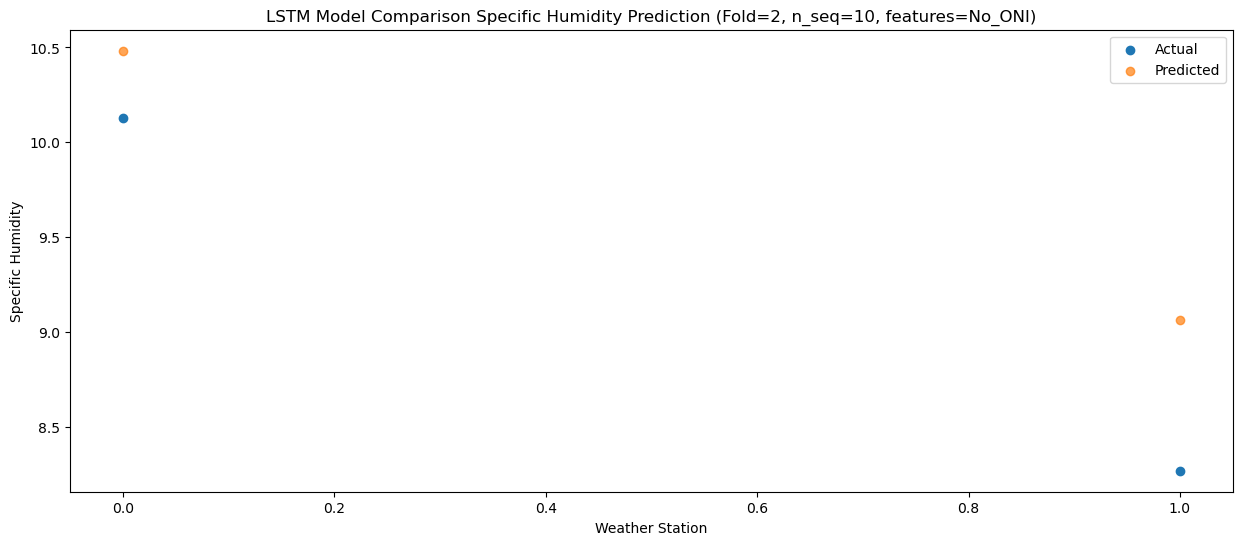

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   10.03  10.134881
1                1    8.54   8.714881


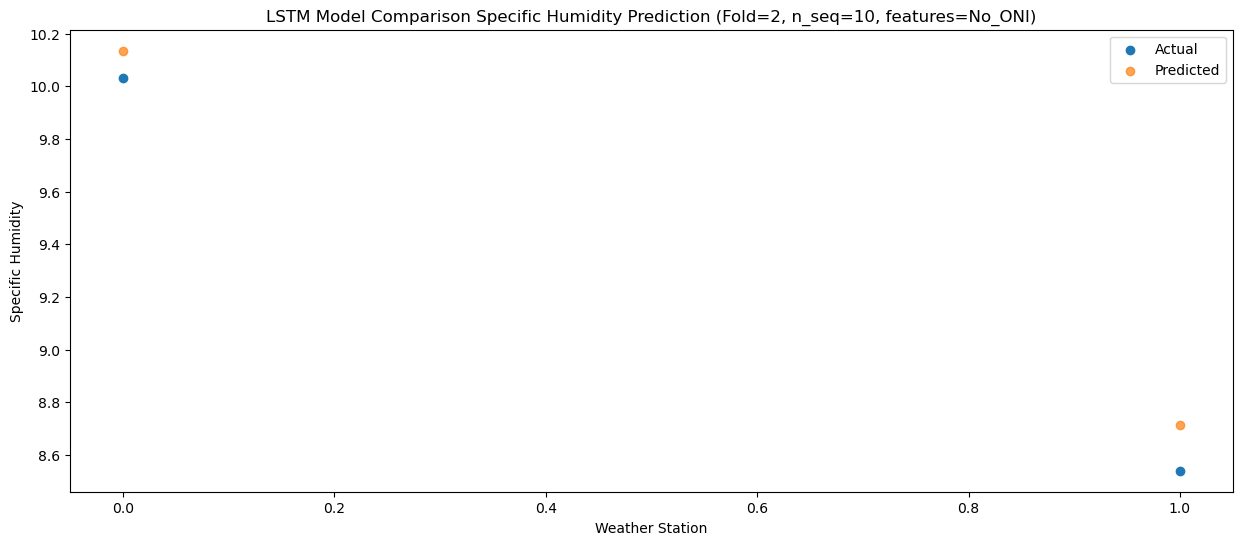

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   10.30  10.516672
1                1    8.55   9.096672


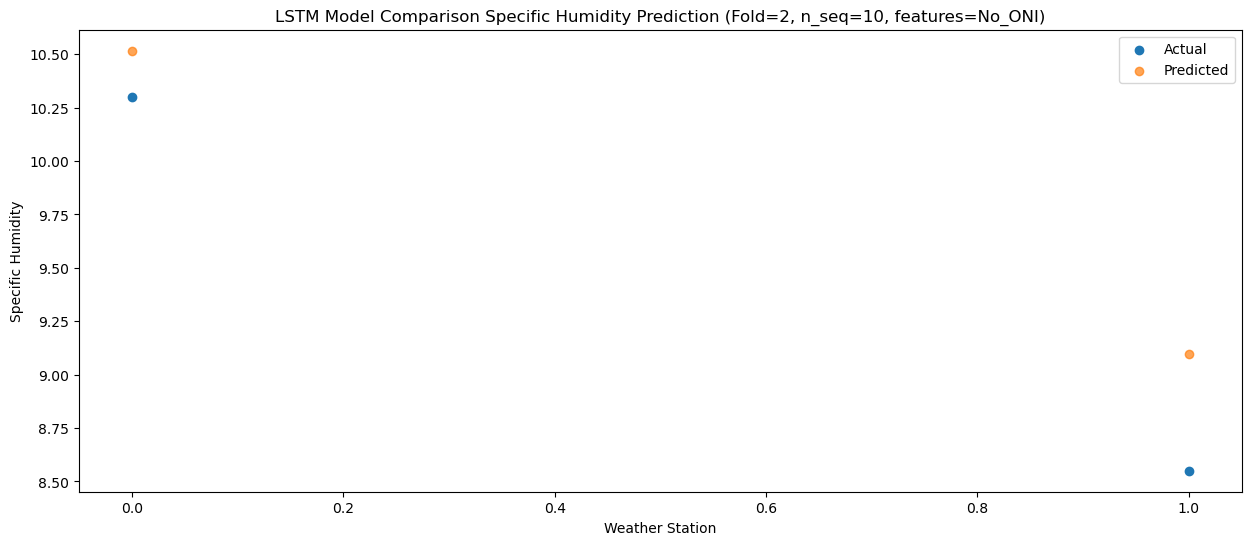

f, t:
[[ 9.72  7.68]
 [10.69  8.43]
 [10.26  8.98]
 [10.94  8.93]
 [11.34  9.03]
 [11.07  8.38]
 [10.54  8.2 ]
 [10.13  8.27]
 [10.03  8.54]
 [10.3   8.55]]
[[ 9.82168366  8.40168366]
 [10.49046637  9.07046637]
 [10.57203914  9.15203914]
 [10.64668157  9.22668157]
 [10.72573038  9.30573038]
 [10.47912811  9.05912811]
 [10.23560737  8.81560737]
 [10.48261814  9.06261814]
 [10.13488068  8.71488068]
 [10.51667242  9.09667242]]
Year at t+1:
t+1 SKRMSE: 0.515348
t+1 KRMSE: 0.515348
t+1 MAE: 0.411684
t+1 SKMAPE: 0.052215
t+1 R2_SCORE: 0.744729
t+1 KMAPE: 0.052215
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 8.700000
Year at t+2:
t+2 SKRMSE: 0.474347
t+2 KRMSE: 0.474347
t+2 MAE: 0.420000
t+2 SKMAPE: 0.047320
t+2 R2_SCORE: 0.823788
t+2 KMAPE: 0.047320
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 9.560000
Year at t+3:
t+3 SKRMSE: 0.251958
t+3 KRMSE: 0.251958
t+3 MAE: 0.242039
t+3 SKMAPE: 0.024786
t+3 R2_SCORE: 0.845012
t+3 KMAPE: 0.024786
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 9.620000
Year at t+4

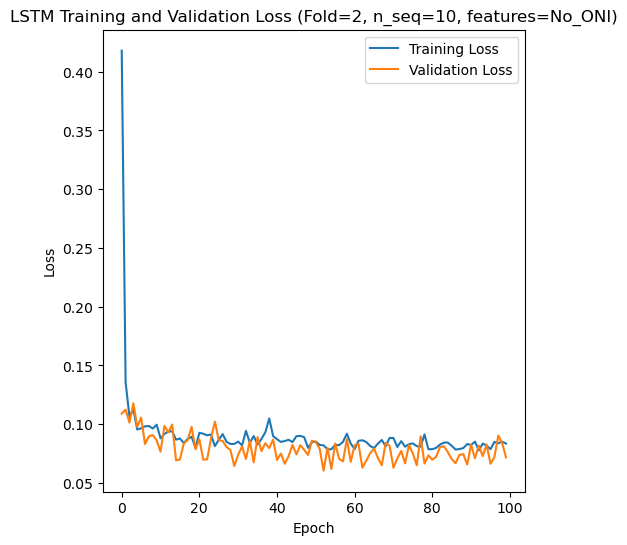

[[4.45 7.03 7.66 7.5  7.   7.5  6.8  7.19 6.85 6.32 6.46 6.61 7.06 6.53
  6.68 6.3  6.77 6.95 6.79 7.44 7.02 7.12 7.47 7.01 6.62 7.19 7.31]
 [8.33 7.39 7.85 8.23 8.15 7.91 8.01 7.7  7.52 7.54 7.12 7.57 7.71 8.23
  7.93 7.83 7.45 8.09 8.19 8.01 8.37 8.25 8.16 8.13 7.66 7.68 8.3 ]]
Epoch 1/100
20/20 [==============================] - 5s 86ms/step - loss: 0.3561 - accuracy: 0.2000 - mae: 0.2984 - rmse: 0.3561 - mape: 51.2956 - pearson: 0.1823 - val_loss: 0.1865 - val_accuracy: 0.0000e+00 - val_mae: 0.1634 - val_rmse: 0.1865 - val_mape: 27.8914 - val_pearson: 0.0780
Epoch 2/100
20/20 [==============================] - 0s 8ms/step - loss: 0.1794 - accuracy: 0.2500 - mae: 0.1517 - rmse: 0.1794 - mape: 26.3861 - pearson: 0.1365 - val_loss: 0.1707 - val_accuracy: 0.0000e+00 - val_mae: 0.1298 - val_rmse: 0.1707 - val_mape: 19.6754 - val_pearson: 0.0313
Epoch 3/100
20/20 [==============================] - 0s 8ms/step - loss: 0.1482 - accuracy: 0.4500 - mae: 0.1221 - rmse: 0.1482 - mape: 21.7460 

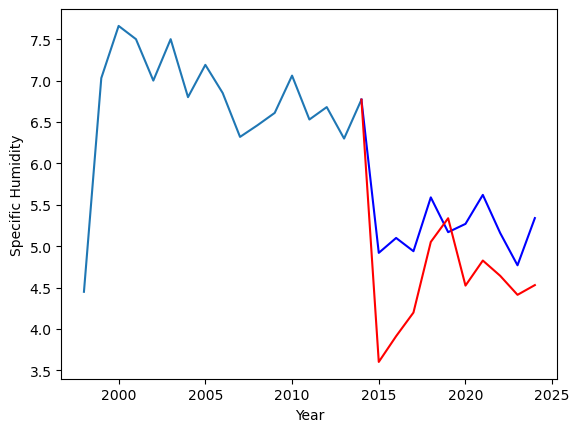

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.95		7.48		-0.47
8.59		7.79		-0.80
8.69		8.08		-0.61
8.51		8.93		0.42
8.87		9.22		0.35
8.75		8.40		-0.35
8.66		8.71		0.05
8.63		8.52		-0.11
8.16		8.29		0.13
8.18		8.41		0.23


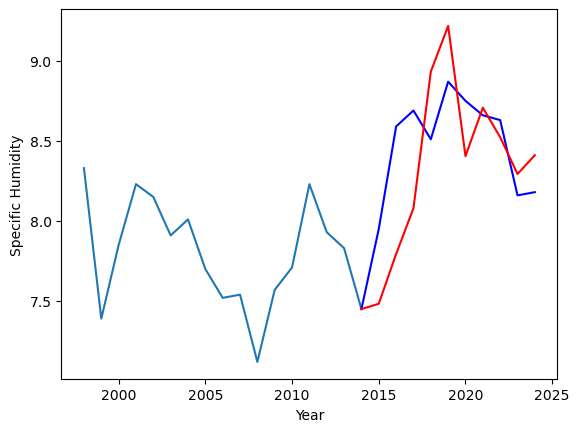

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    4.92   3.603294
1                1    7.95   7.483294


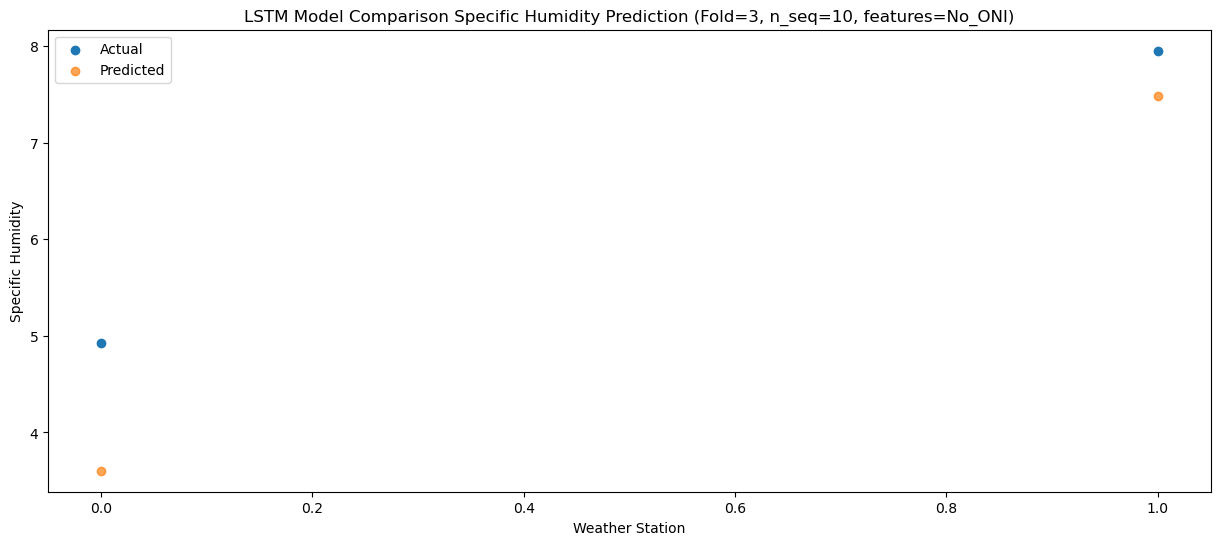

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0    5.10   3.914029
1                1    8.59   7.794029


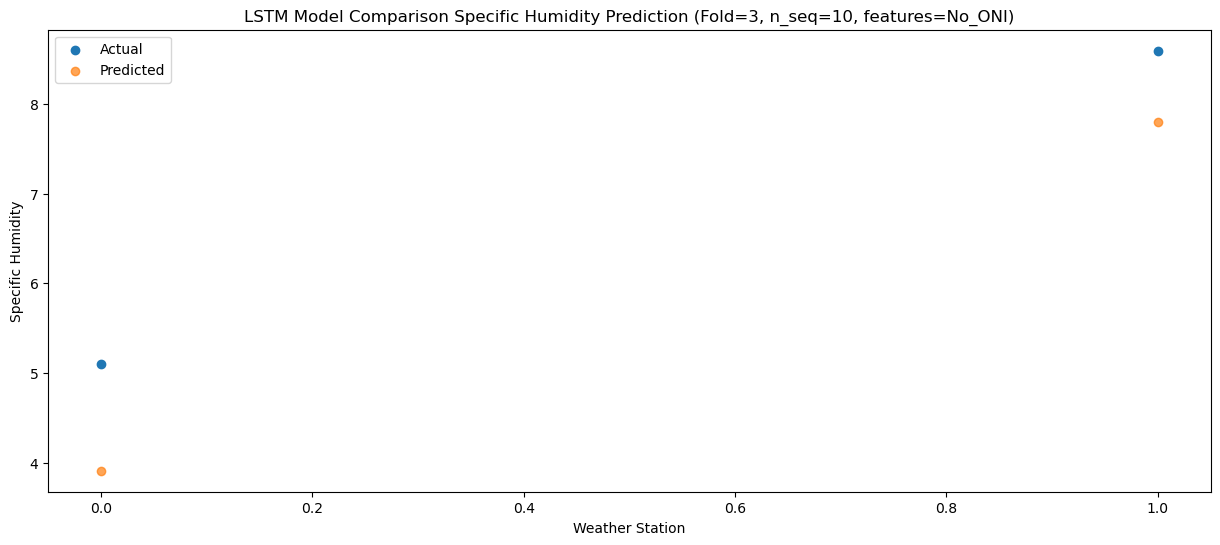

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0    4.94   4.199263
1                1    8.69   8.079263


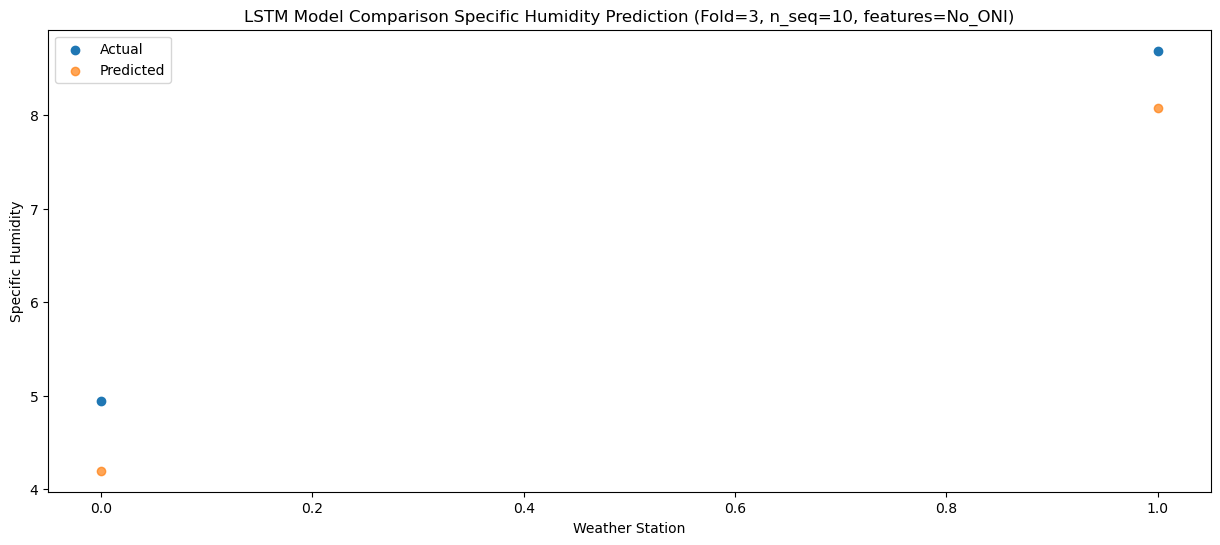

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0    5.59   5.052093
1                1    8.51   8.932093


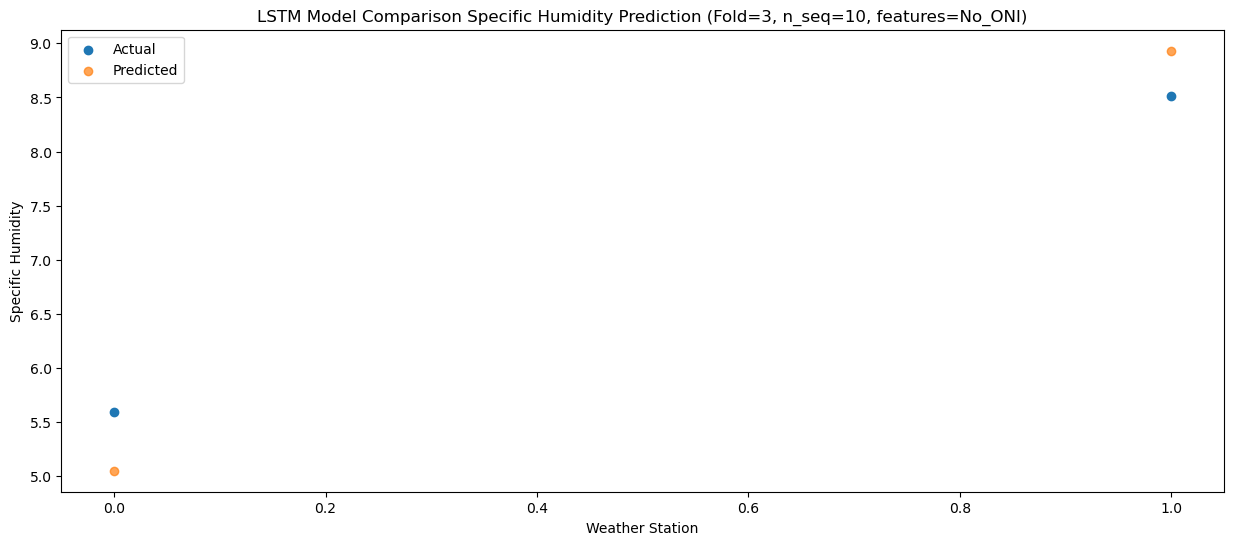

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0    5.17   5.338008
1                1    8.87   9.218008


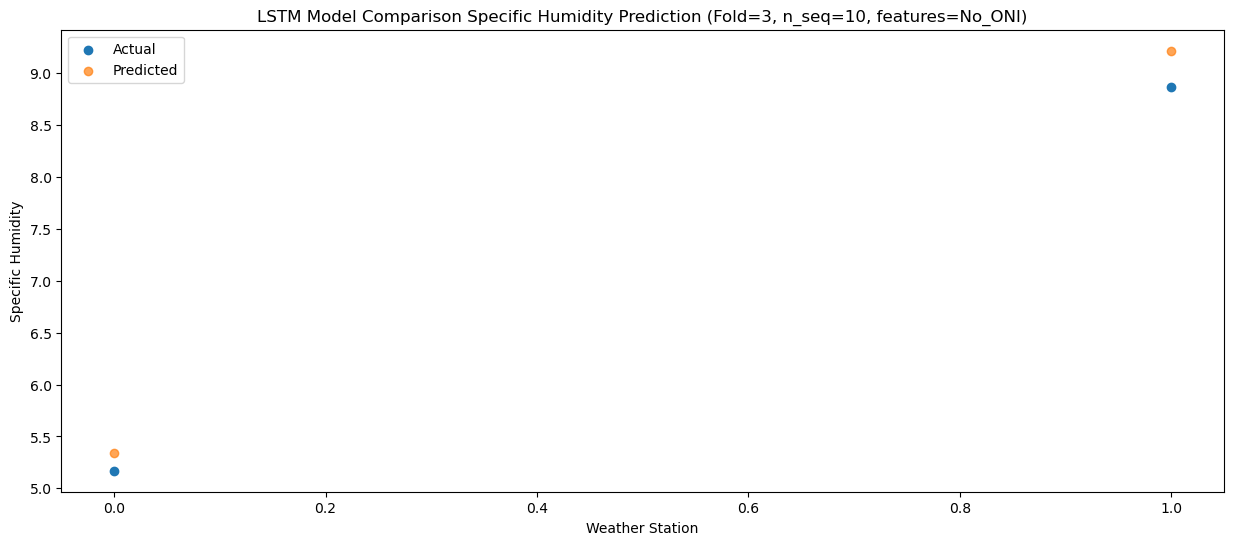

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0    5.27   4.524689
1                1    8.75   8.404689


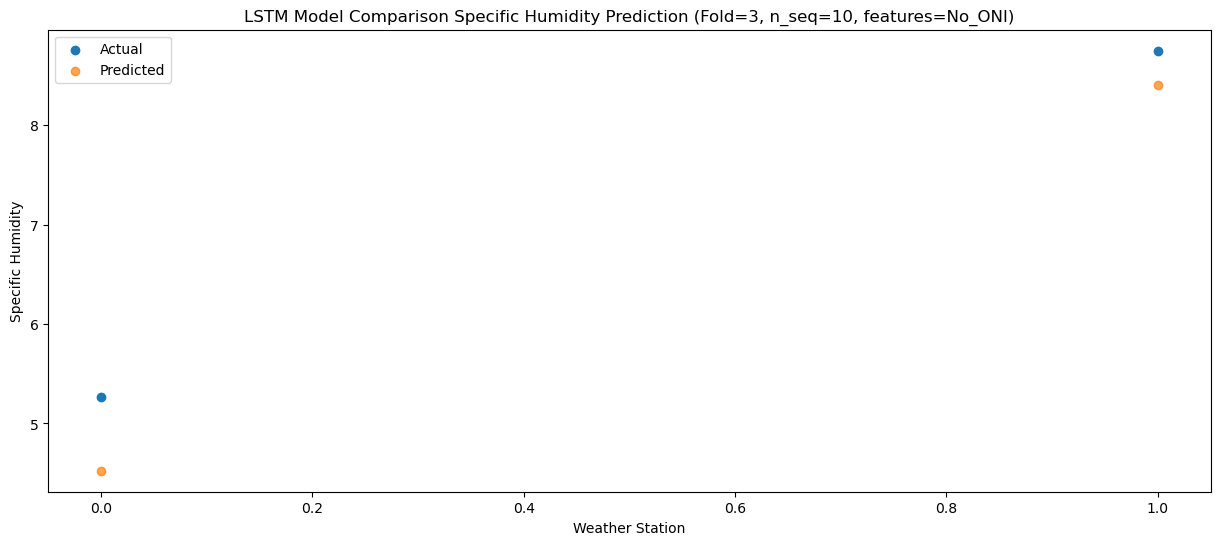

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0    5.62   4.827398
1                1    8.66   8.707399


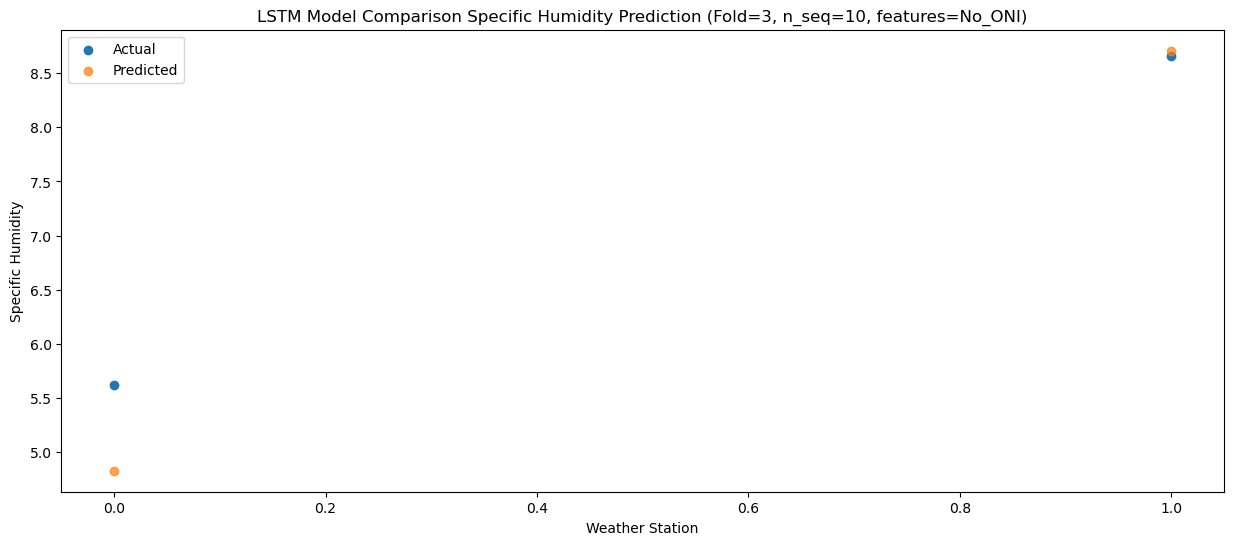

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0    5.16   4.643217
1                1    8.63   8.523218


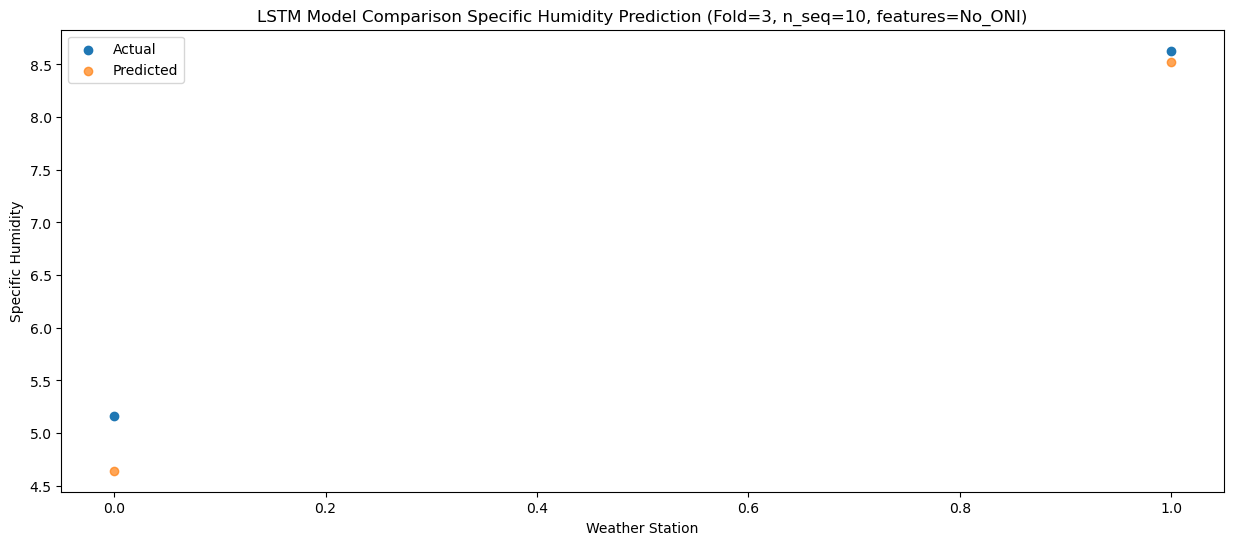

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0    4.77   4.413436
1                1    8.16   8.293436


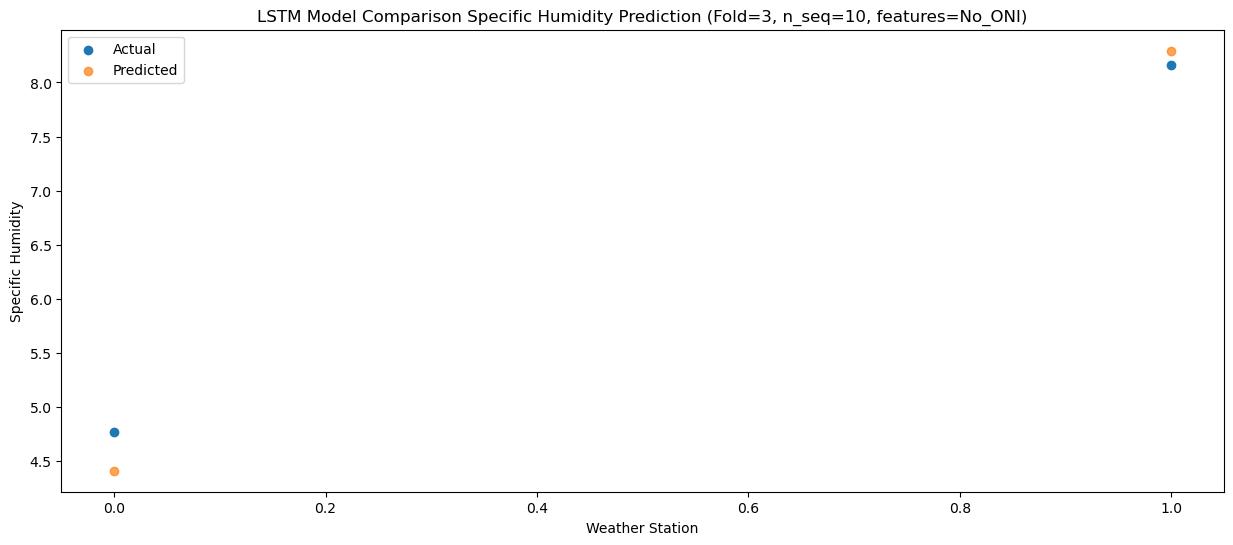

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0    5.34   4.530982
1                1    8.18   8.410982


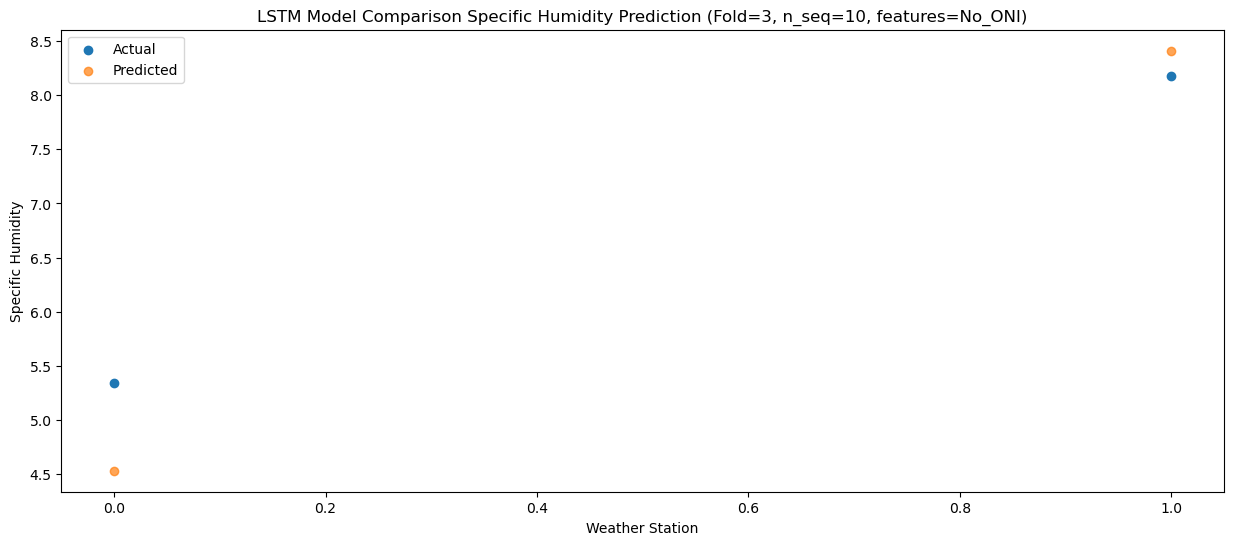

f, t:
[[4.92 7.95]
 [5.1  8.59]
 [4.94 8.69]
 [5.59 8.51]
 [5.17 8.87]
 [5.27 8.75]
 [5.62 8.66]
 [5.16 8.63]
 [4.77 8.16]
 [5.34 8.18]]
[[3.60329427 7.48329427]
 [3.9140291  7.7940291 ]
 [4.19926257 8.07926257]
 [5.05209292 8.93209292]
 [5.33800791 9.21800791]
 [4.52468942 8.40468942]
 [4.82739831 8.70739852]
 [4.64321747 8.52321768]
 [4.41343607 8.29343628]
 [4.5309815  8.41098171]]
Year at t+1:
t+1 SKRMSE: 0.987808
t+1 KRMSE: 0.987808
t+1 MAE: 0.891706
t+1 SKMAPE: 0.163164
t+1 R2_SCORE: 0.574872
t+1 KMAPE: 0.163164
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 6.435000
Year at t+2:
t+2 SKRMSE: 1.009974
t+2 KRMSE: 1.009974
t+2 MAE: 0.990971
t+2 SKMAPE: 0.162603
t+2 R2_SCORE: 0.665012
t+2 KMAPE: 0.162603
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 6.845000
Year at t+3:
t+3 SKRMSE: 0.678856
t+3 KRMSE: 0.678856
t+3 MAE: 0.675737
t+3 SKMAPE: 0.110114
t+3 R2_SCORE: 0.868915
t+3 KMAPE: 0.110114
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 6.815000
Year at t+4:
t+4 SKRMSE: 0.483480
t+4 KRMSE: 0.4834

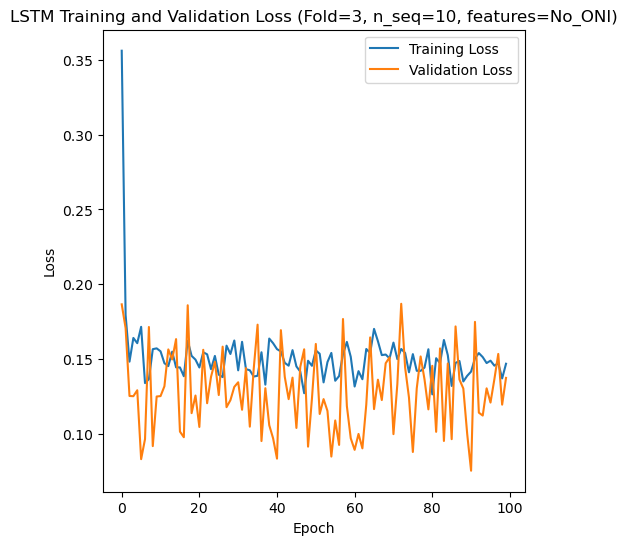

[[11.16  9.55  9.55 10.04  9.82  9.68 10.08  8.81  8.71 10.02  8.91  9.32
   9.71  8.86  9.35  8.98  8.99  9.85 10.25 10.41  9.69  9.69  9.59  9.94
   9.15  9.7  10.89]
 [ 8.33  7.32  7.52  7.52  7.95  7.22  7.21  7.13  7.15  7.14  7.22  7.24
   7.84  7.63  7.34  7.44  7.18  7.84  8.31  7.98  8.38  7.84  7.57  7.9
   7.3   7.53  8.43]]
Epoch 1/100
19/19 [==============================] - 6s 79ms/step - loss: 0.3994 - accuracy: 0.2105 - mae: 0.3340 - rmse: 0.3994 - mape: 77.6472 - pearson: 0.1939 - val_loss: 0.1256 - val_accuracy: 0.0000e+00 - val_mae: 0.1034 - val_rmse: 0.1256 - val_mape: 24.0341 - val_pearson: 0.1087
Epoch 2/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1063 - accuracy: 0.3684 - mae: 0.0867 - rmse: 0.1063 - mape: 20.8687 - pearson: 0.1942 - val_loss: 0.1445 - val_accuracy: 0.0000e+00 - val_mae: 0.1166 - val_rmse: 0.1445 - val_mape: 26.2725 - val_pearson: 0.0209
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1108 - accur

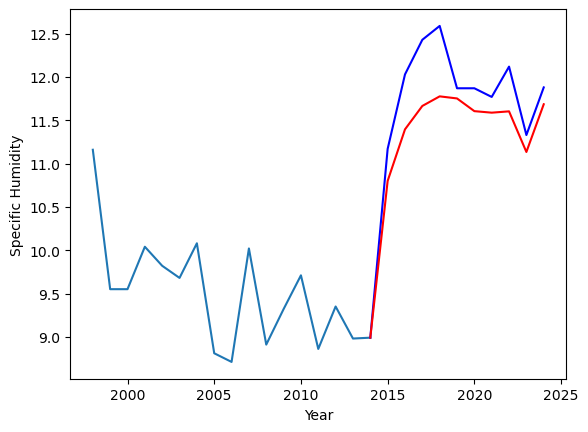

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.07		7.97		-0.10
8.73		8.57		-0.16
9.20		8.84		-0.36
8.87		8.95		0.08
9.27		8.92		-0.35
8.73		8.78		0.05
8.46		8.76		0.30
8.79		8.77		-0.02
8.19		8.30		0.11
8.42		8.86		0.44


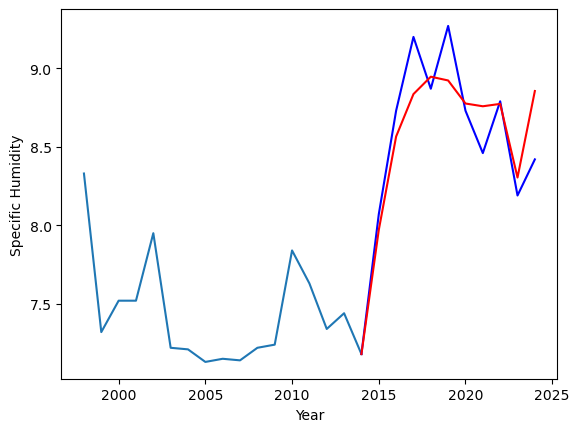

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.17  10.800166
1                1    8.07   7.970167


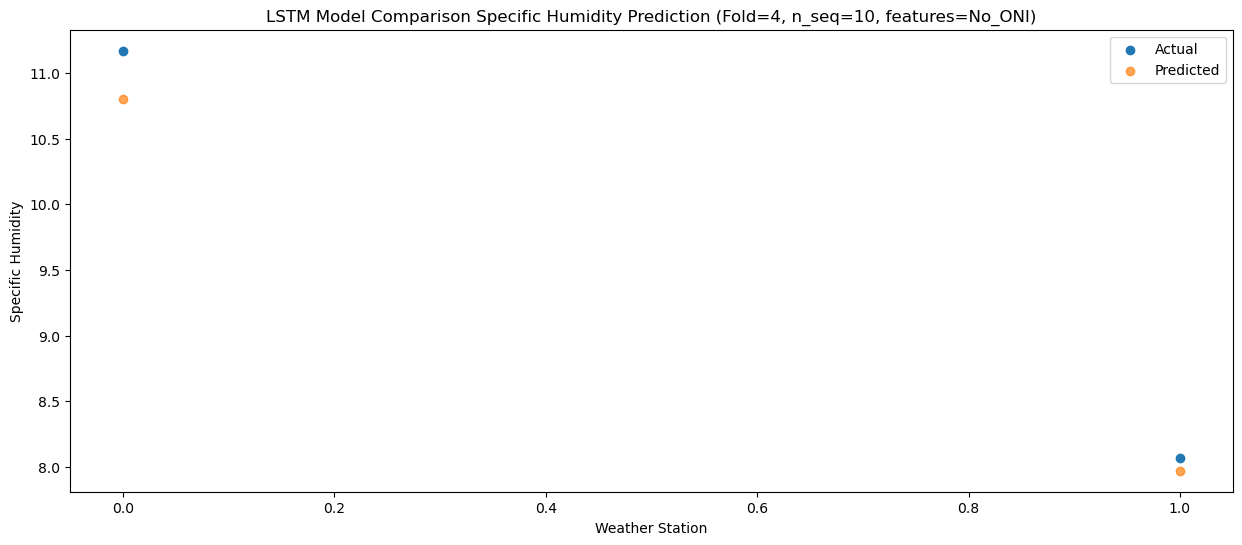

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   12.03  11.395543
1                1    8.73   8.565543


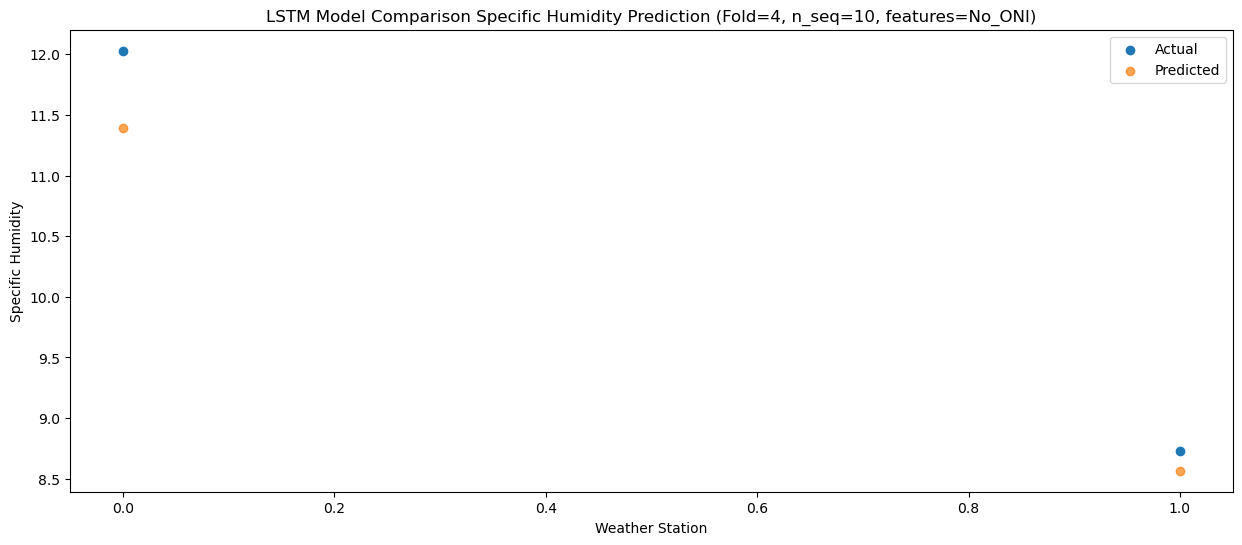

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   12.43  11.665883
1                1    9.20   8.835883


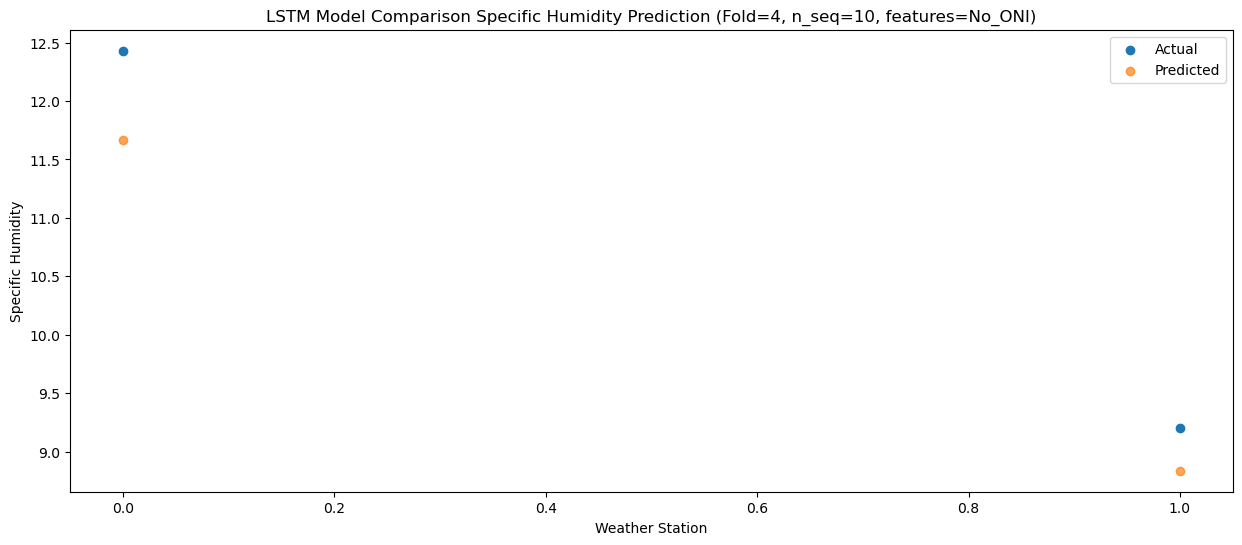

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   12.59  11.776609
1                1    8.87   8.946609


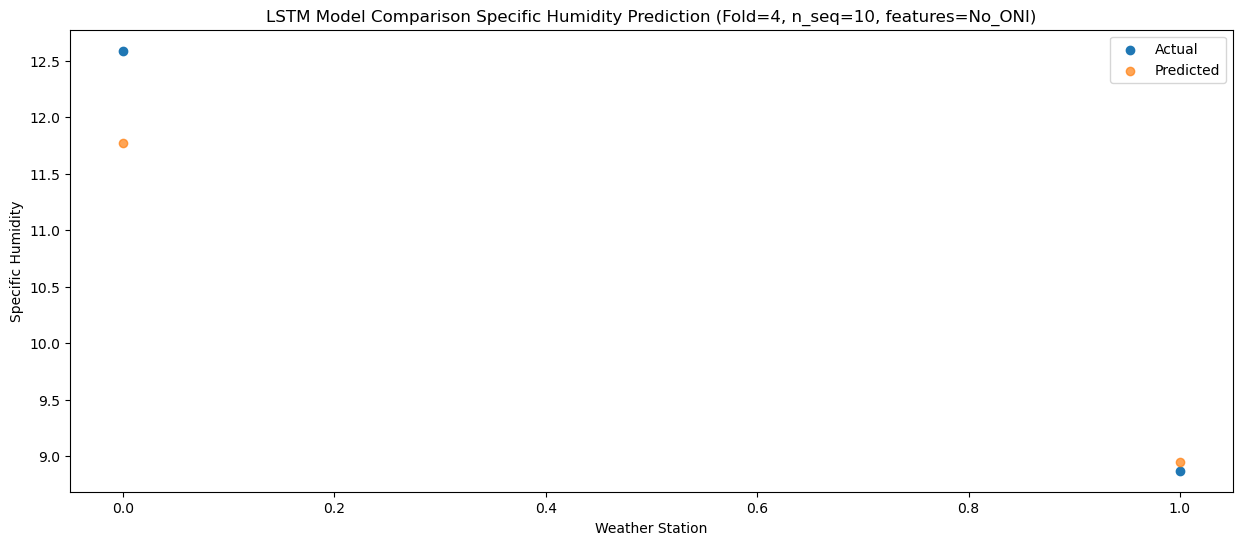

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   11.87  11.752575
1                1    9.27   8.922575


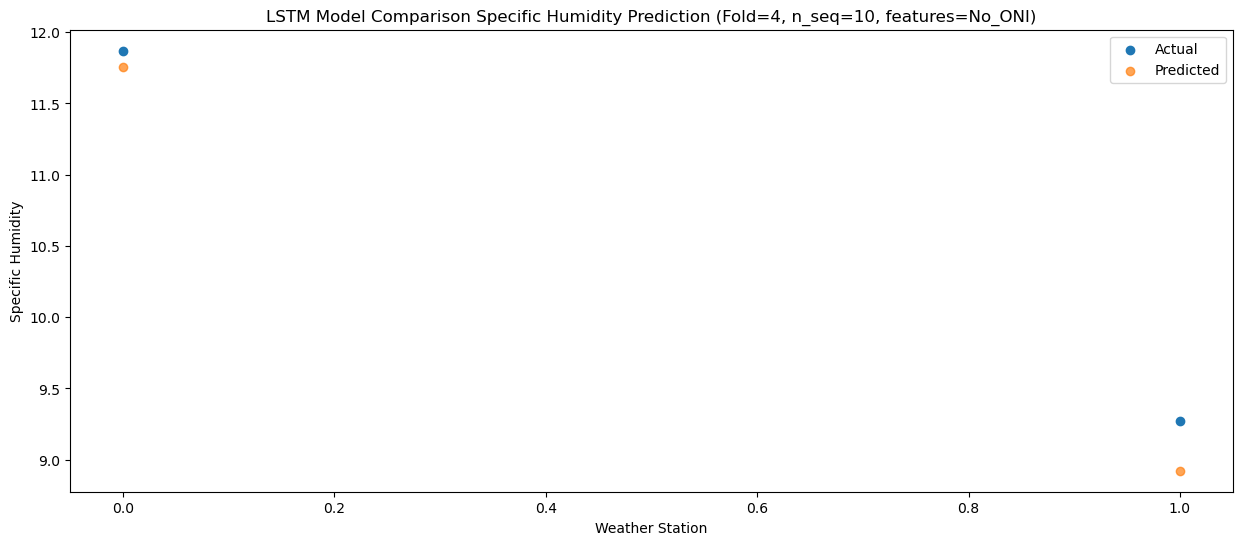

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   11.87  11.605841
1                1    8.73   8.775841


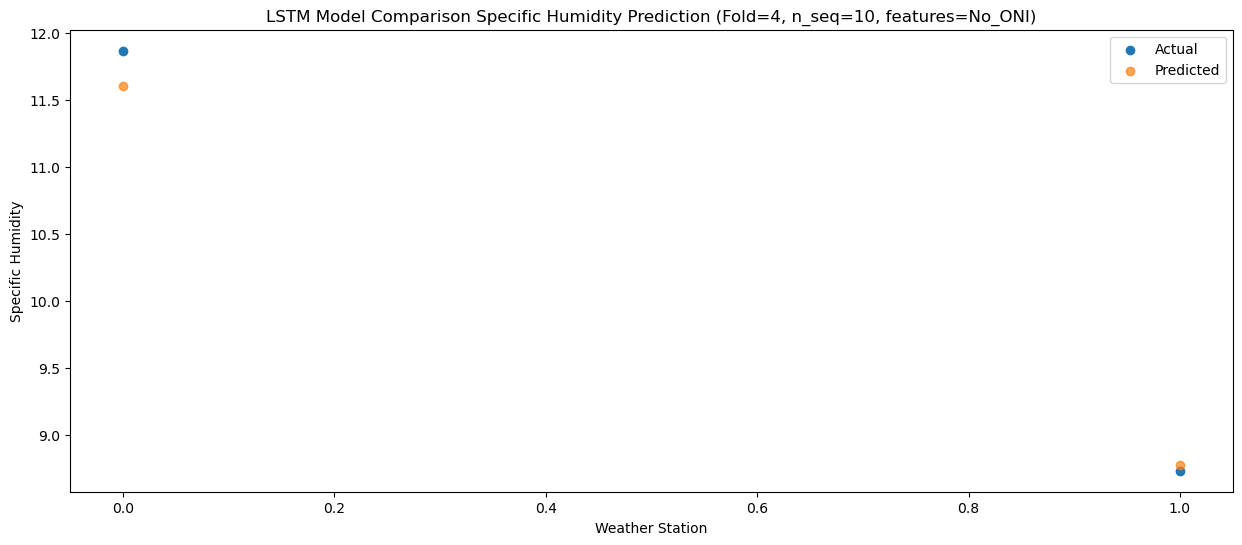

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   11.77  11.588261
1                1    8.46   8.758261


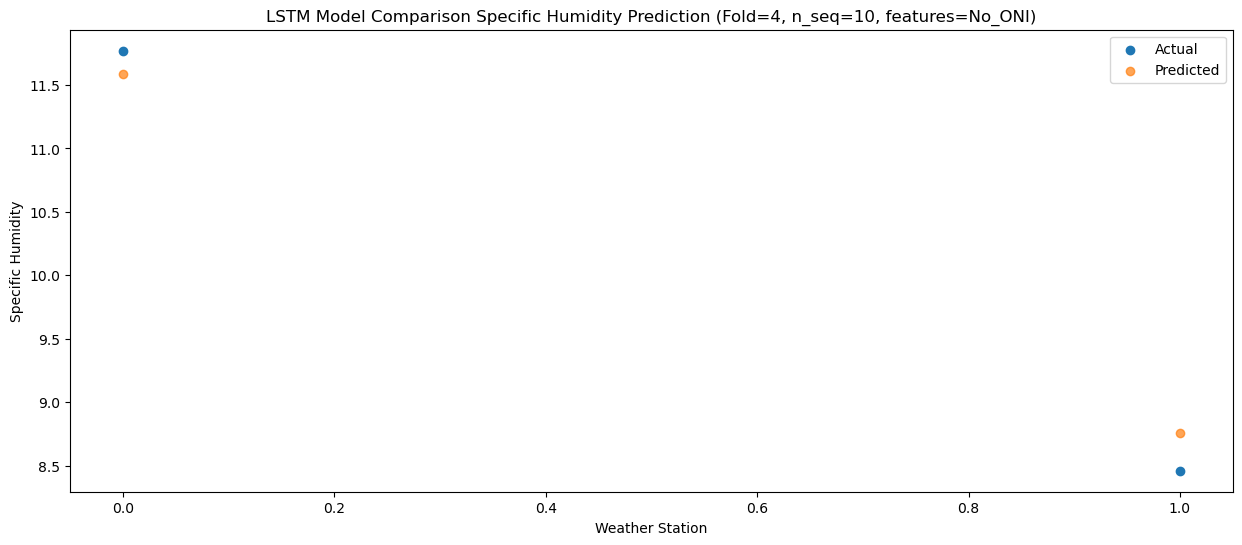

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   12.12  11.603414
1                1    8.79   8.773414


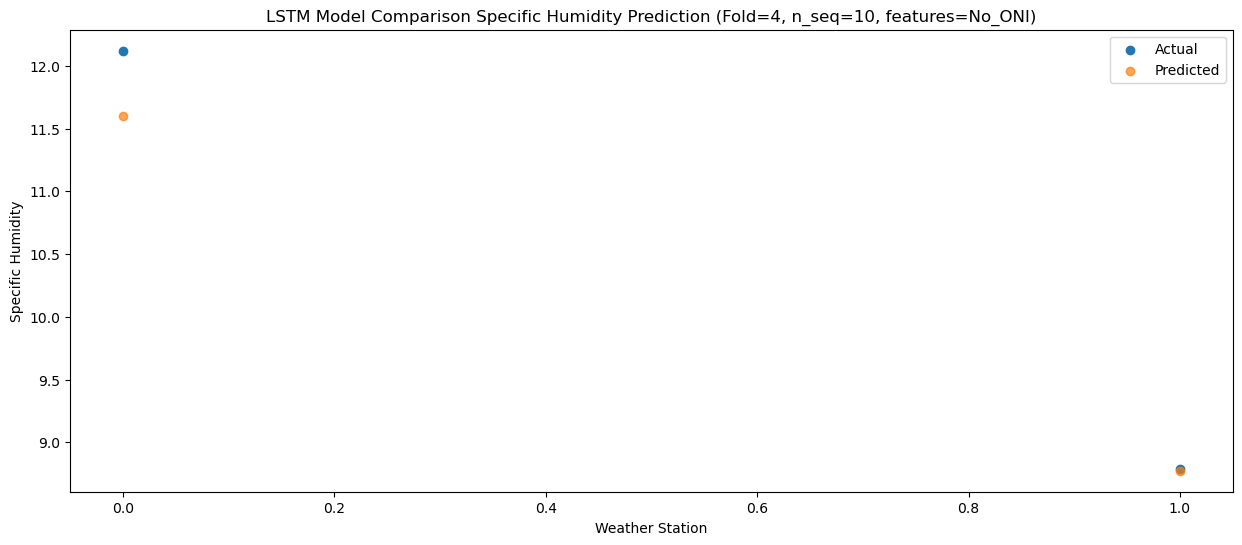

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   11.33  11.134327
1                1    8.19   8.304327


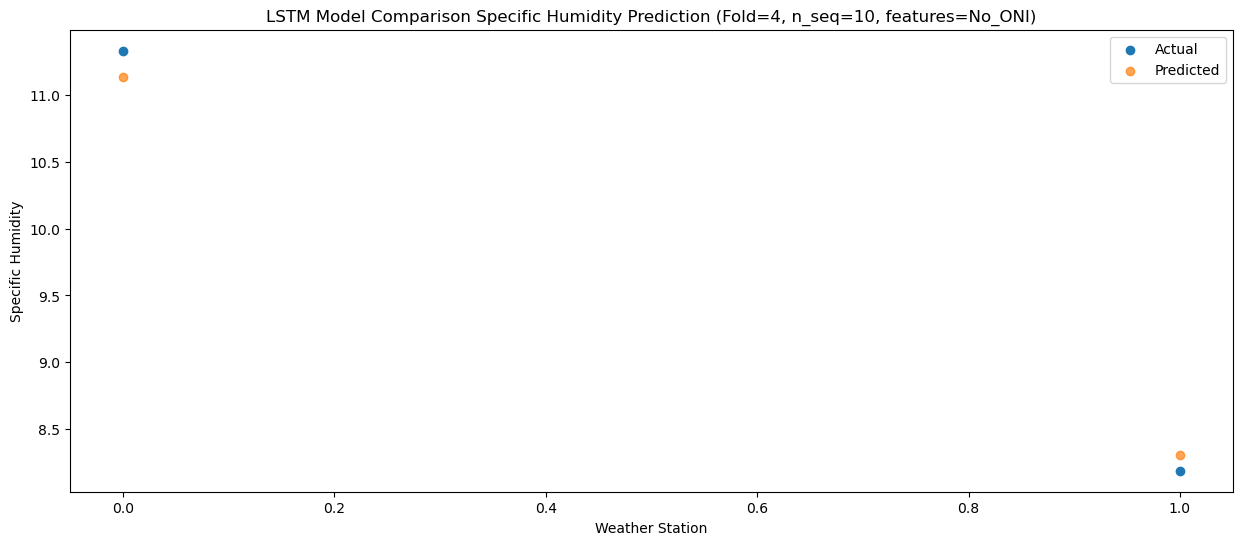

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   11.88  11.685434
1                1    8.42   8.855434


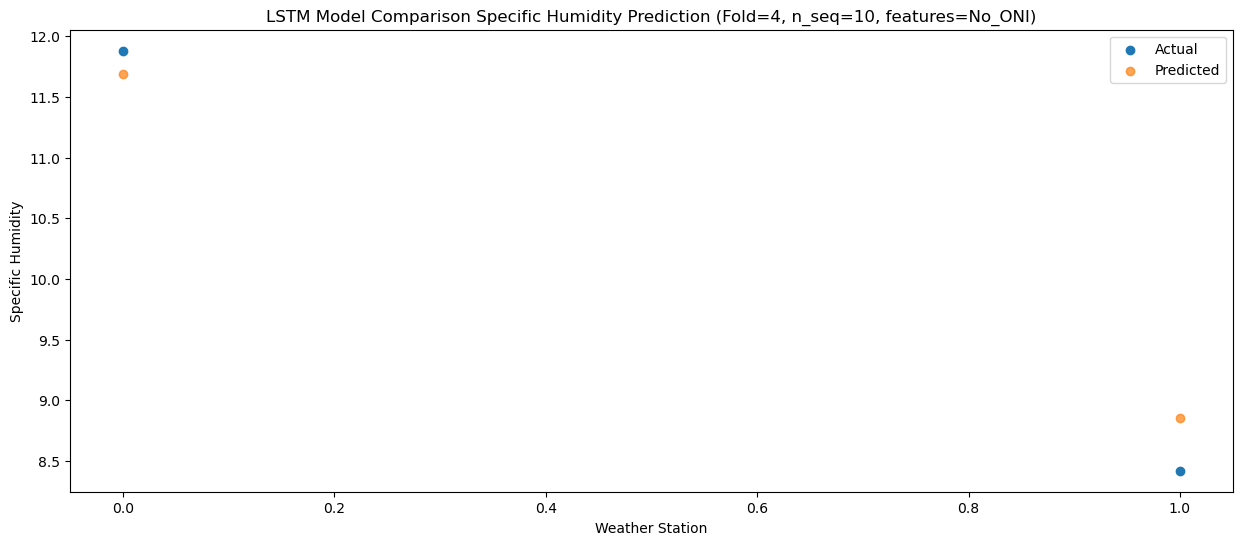

f, t:
[[11.17  8.07]
 [12.03  8.73]
 [12.43  9.2 ]
 [12.59  8.87]
 [11.87  9.27]
 [11.87  8.73]
 [11.77  8.46]
 [12.12  8.79]
 [11.33  8.19]
 [11.88  8.42]]
[[10.80016649  7.97016664]
 [11.39554298  8.56554313]
 [11.66588319  8.83588334]
 [11.77660879  8.94660881]
 [11.75257529  8.92257531]
 [11.60584097  8.77584098]
 [11.58826121  8.75826123]
 [11.60341416  8.77341418]
 [11.1343271   8.30432711]
 [11.68543421  8.85543422]]
Year at t+1:
t+1 SKRMSE: 0.270872
t+1 KRMSE: 0.270872
t+1 MAE: 0.234833
t+1 SKMAPE: 0.022740
t+1 R2_SCORE: 0.969460
t+1 KMAPE: 0.022740
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.620000
Year at t+2:
t+2 SKRMSE: 0.463455
t+2 KRMSE: 0.463455
t+2 MAE: 0.399457
t+2 SKMAPE: 0.035789
t+2 R2_SCORE: 0.921105
t+2 KMAPE: 0.035789
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 10.380000
Year at t+3:
t+3 SKRMSE: 0.598521
t+3 KRMSE: 0.598521
t+3 MAE: 0.564117
t+3 SKMAPE: 0.050526
t+3 R2_SCORE: 0.862655
t+3 KMAPE: 0.050526
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 10.815000
Year at t

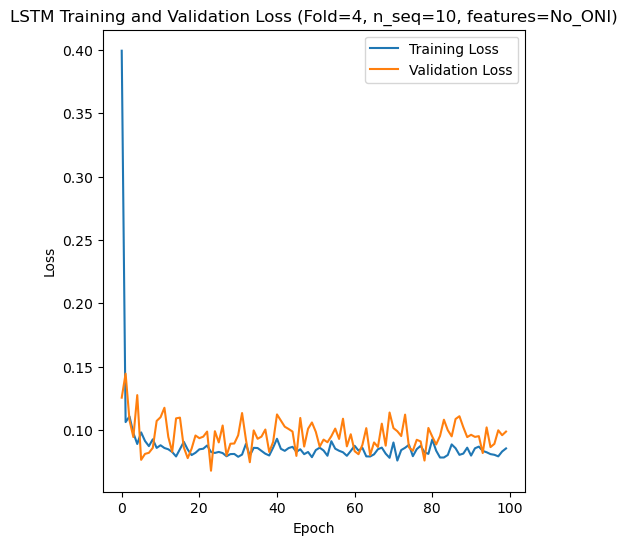

[[0.4998148145435687], [0.5868379779272687], [0.45593253466763034], [0.6311348572250166], [0.37646851932835573]]
[[array(0.49981481)], [array(0.58683798)], [array(0.45593253)], [array(0.63113486)], [array(0.37646852)]]
[[0.4094229684472088], [0.49187003955245007], [0.40028940454125356], [0.5338515288233758], [0.300741767901927]]
[[0.03374010979387804], [0.04970043992177052], [0.043915595110921475], [0.09000406572770263], [0.028037812978833683]]
[[0.8953657165133506], [0.9055930674243722], [0.8261955062648578], [0.8585352377417301], [0.9487972084942721]]
[[array(0.03374011)], [array(0.04970044)], [array(0.0439156)], [array(0.09000407)], [array(0.02803781)]]
[[array(0.93557132)], [array(0.9717543)], [array(0.93649176)], [array(0.96010204)], [array(0.97827693)]]
[12.78 13.83 13.92 14.3  13.46 13.41 13.53 13.34 13.05 13.36  9.71 10.79
 10.2  10.87 10.99 10.8  11.01 10.57 10.05 10.24 11.42 12.26 11.81 12.26
 12.81 12.14 12.5  11.83 11.88 11.74  7.95  9.08  9.06  8.69  8.53  8.56
  7.82  8.2

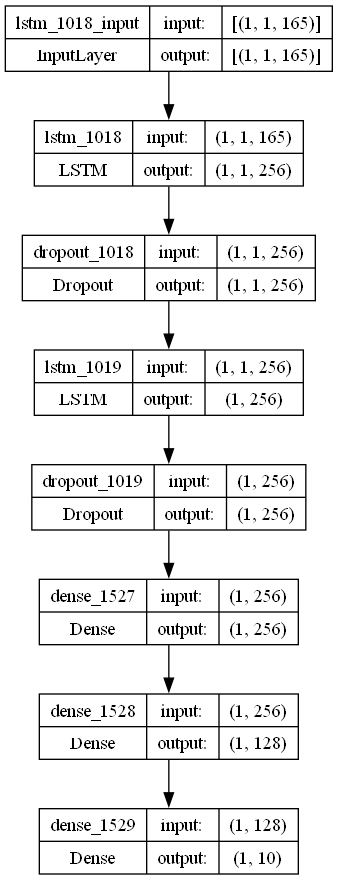

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    lr = 0.014463668045274741 
    optimizer = Adam(learning_rate = lr)
    activation_function = 'sigmoid'
    lstm_units = 256
    dropout_rate = 0.23143443114203002

    # design network
    model = Sequential()
    #model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with an LSTM,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (specific_humidity)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_ONI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_ONI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))
print("")
print("Average Specific Humidity:"+str(np.mean(actual_avg_list)))
print("RMSE % of Specific Humidity:"+str(np.mean(rmse2_avg_list)/np.mean(actual_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_SH_S10_No_ONI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)